# Q3.1: Revised Team 22 Project
### Comments received
1. You may consider using geographical features to differentiate the carparks from each other.
Also, instead of using one ML model per carpark, we would recommend to use one model for all carparks.

2. The “web/phone application or integration with established wayfinding applications” is interesting and a good purpose, but it does not suit the theme of this module as much as doing data analysis. Do allocate your time and resources wisely if your team decide to do this.

### Revision of project
Having internalised the comments, we have decided to use a model for all carparks. By comparing 3 models (MLP,LR and LSTM), we will use the final selected model to predict a user-specified carpark availability for the next 24 hours.


### Preamble
With the steadily increasing motor vehicle population in Singapore of 957,006 in 2018 to 988,755 in 2021, parking demand also experiences an upward trend. Parking has become a major traffic issue for not only vehicle owners but also to local authorities in charge of allocating scarce land resources. 

### Proposed Solution
In summary, our group wishes to create a carpark recommendation system with the ability to forecast demand. Determining the carpark’s demand at certain timeframes will be done using time-series forecast which utilised historical data to predict future demand trends. This system generally benefits vehicle owners but can be extended to be gain insights into state planning (land allocation for vehicle parking or congestion). 

From a user’s perspective, users could provide the destination (in GPS 
coordinates) and the system will provide the top-n nearest carparks and their respective current available lots. If users were to specify a timeframe in the future, they will be able to view a demand forecast graph (as seen in figure below) in hourly intervals. This feature allows users to plan their trips accordingly to avoid peak demand periods. 

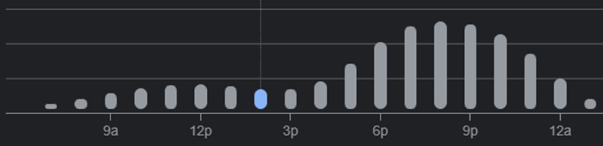


In [1]:
import pandas as pd
import numpy as np

# Data cleaning and preparation

We will train our model using data from July to September 2022. We start by loading data from CSV files.

In [2]:
def load_data(month, days=31):
    full_df = pd.read_csv(f"./data/2022-{str(month)}-1.csv")
    for date in range(2, days+1):
        test_df = pd.read_csv(f'./data/2022-{str(month)}-{date}.csv')
        full_df = pd.concat([full_df, test_df])
    full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])
    full_df = full_df.set_index('timestamp')
    return full_df

In [3]:
jul = load_data(7)
aug = load_data(8)
sep = load_data(9, days=30)
full_data = pd.concat([jul, aug, sep])
full_data.dropna(inplace=True)

In [4]:
full_data['available rate'] = full_data['lots_available'] / full_data['total_lots']
full_data.dropna(inplace=True)
grped_full = full_data.groupby(full_data.carpark_number)

For each carpark, we use the first 70% as training data and last 30% as testing data. We will use previous 8*24 hours availability as features and the next 24 hours availability as output.
We slice out the data for each carpark and resample them to fill in missing values. Then we prepare training and testing features and labels.

In [6]:
# helper method to create inputs and outputs from a given dataset
def prep_train_test(dataset, feature_len):
    X = []
    Y = []
    for i in range(feature_len, len(dataset)-24):
        X.append(dataset['available rate'][i-feature_len:i].values)
        Y.append(dataset['available rate'][i:i+24].values)
    return X, Y

In [7]:
carparks = grped_full.carpark_number.unique()
print(carparks)
trainX, trainY = [], []
testX, testY = [], []
feature_len = 24*8
split = 0.3
print("total ids:", len(carparks))
index = 0
for id in carparks:
    slice = grped_full.get_group(id[0])
    slice = slice.resample('1h').mean()
    if slice.shape[0] != 2208:
        print(slice.shape[0])
        print("Lossy data. Dropped")
        continue
    if slice.isnull().values.any():
        slice.fillna(method='ffill', inplace=True)
    split_index = int(slice.shape[0] * split)
    X_train1, Y_train1 = prep_train_test(slice[:split_index], feature_len)
    X_test1, Y_test1 = prep_train_test(slice[split_index:], feature_len)
    trainX.extend(X_train1)
    trainY.extend(Y_train1)
    testX.extend(X_test1)
    testY.extend(Y_test1)
    index += 1
    if index % 100 == 0:
        print(index, "done")
trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
testY = np.array(testY)


carpark_number
A10      [A10]
A100    [A100]
A11      [A11]
A12      [A12]
A13      [A13]
         ...  
Y78M    [Y78M]
Y8        [Y8]
Y82M    [Y82M]
Y9        [Y9]
YHS      [YHS]
Name: carpark_number, Length: 1965, dtype: object
total ids: 1965
855
Lossy data. Dropped
100 done
200 done
300 done
400 done
500 done
730
Lossy data. Dropped
730
Lossy data. Dropped
600 done
700 done
800 done
900 done
1000 done
1100 done
83
Lossy data. Dropped
1200 done
1300 done
1400 done
1500 done
1600 done
1700 done
1800 done
1900 done


In [8]:
display(testY)

array([[0.6640625 , 0.625     , 0.625     , ..., 0.40234375, 0.4140625 ,
        0.42578125],
       [0.625     , 0.625     , 0.6171875 , ..., 0.4140625 , 0.42578125,
        0.48046875],
       [0.625     , 0.6171875 , 0.5078125 , ..., 0.42578125, 0.48046875,
        0.4609375 ],
       ...,
       [0.328125  , 0.328125  , 0.328125  , ..., 0.328125  , 0.55497159,
        0.328125  ],
       [0.328125  , 0.328125  , 0.328125  , ..., 0.55497159, 0.328125  ,
        0.328125  ],
       [0.328125  , 0.328125  , 0.328125  , ..., 0.328125  , 0.328125  ,
        0.328125  ]])

In [9]:
print("train test length:", trainX.shape, trainY.shape)
print("testing test length:", testX.shape, testY.shape)
print("input shape:", trainX[0].shape)
print("output shape:", trainY[0].shape)

train test length: (874606, 192) (874606, 24)
testing test length: (2608130, 192) (2608130, 24)
input shape: (192,)
output shape: (24,)


# Finding the best model
The following section shows the deliberation behind the decision of the final model. This is an extension of question 2 where we have found the linear regression model to be the best performing out of the 3 pre-selected models with Support Vector Regressor and Decision Tree Regressor models as the alternatives. Here, we have experimented with Multi-layer Perceptron(MLP) and Long Short-Term Memory(LSTM) models to arrive at our final decided model used in our simulated application where users can see the predicted availability of a carpark.

# Model 1: Multi-layer perceptron (MLP)

### In this section, we will use MLP model to predict the parking availability within the next 24 hours

In [10]:
# Import libraries
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error



In [11]:
## Q3 data
print(trainX.dtype,trainY.dtype)
print(testX.dtype,testY.dtype)
print(np.isnan(trainX).any() ,np.isnan(trainY).any())
print(np.isnan(testX).any() ,np.isnan(testY).any())
print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)

float64 float64
float64 float64
False False
False False
(874606, 192) (874606, 24)
(2608130, 192) (2608130, 24)


#### MLP regressor

In [ ]:
#Train the data with MLP regressor
model = MLPRegressor(activation='relu', hidden_layer_sizes=(200, 50),
             max_iter=50, solver='adam', verbose=True, early_stopping=True)
model.fit(trainX, trainY)
print(model)

In [ ]:
# Saving the model
import pickle
filename = 'models/mlp_sklearn_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [12]:
# Loading the model
import pickle
model = pickle.load(open('models/mlp_sklearn_model.sav', 'rb'))
Y_pred = model.predict(testX)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
# Function to map testId to Carpark Id with dropped data accounted for
def mapTestIdToCarpark(testId):
    arr = ["A10","A100","A11","A12","A13","A15","A2","A20","A21","A24","A25","A26","A27","A28","A29","A30","A31","A33","A34","A35","A36","A37","A38","A39","A4","A40","A41","A42","A43","A44","A45","A47","A48","A49","A50","A51","A52","A53","A54","A59","A60","A61","A63","A64","A65","A66","A67","A68","A69","A7","A70","A71","A72","A73","A74","A75","A76","A77","A78","A8","A81","A82","A85","A87","A88","A9","A94","A98","ACB","ACM","AH1","ALL","AM14","AM16","AM18","AM19","AM20","AM22","AM32","AM43","AM46","AM51","AM64","AM79","AM80","AM81","AM96","AR1L","AR1M","AR2L","AR2M","AR5M","AR7L","AR7M","AR9","AV1","B10","B10M","B11","B14","B16","B17","B19","B20","B21","B23M","B23T","B24","B25","B26","B27","B28","B30","B31","B32","B33","B34","B35","B40","B41","B42","B43","B44","B44B","B45","B45A","B45B","B46","B47","B48","B48B","B49","B50","B51","B52","B53","B54","B57","B59","B6","B60","B63","B65","B65L","B65M","B66","B67","B69","B7","B70","B71","B71M","B72","B73","B74","B75","B79","B7A","B7B","B8","B80","B81","B83","B84","B85","B86","B88","B88M","B89","B8B","B9","B90","B90M","B91","B92","B94","B94A","B95","B96","B97","B98","B99M","BA1","BA2","BA3","BA4","BB","BB8M","BBB","BBM1","BBM2","BBM3","BBM5","BBM7","BBM8","BBM9","BE10","BE11","BE12","BE13","BE14","BE18","BE19","BE22","BE23","BE232","BE241","BE25","BE26","BE27","BE28","BE29","BE3","BE30","BE31","BE32","BE33","BE34","BE35","BE36","BE37","BE38","BE39","BE3R","BE4","BE40","BE42","BE44","BE45","BE5","BE6","BE7","BE8","BE9","BH1","BH2","BJ1","BJ10","BJ11","BJ12","BJ13","BJ14","BJ15","BJ16","BJ17","BJ18","BJ19","BJ2","BJ20","BJ21","BJ23","BJ24","BJ25","BJ26","BJ27","BJ28","BJ29","BJ3","BJ30","BJ31","BJ32","BJ33","BJ34","BJ35","BJ36","BJ37","BJ38","BJ39","BJ4","BJ40","BJ41","BJ42","BJ43","BJ44","BJ45","BJ48","BJ49","BJ50","BJ51","BJ52","BJ53","BJ54","BJ55","BJ56","BJ57","BJ58","BJ60","BJ61","BJ62","BJ63","BJ65","BJ66","BJ67","BJ68","BJ69","BJ71","BJ72","BJ8","BJAL","BJBL","BJMP","BKE1","BKE2","BKE3","BKE4","BKE7","BKE9","BKRM","BL10","BL13","BL15","BL17","BL18","BL18M","BL19","BL19S","BL22","BL23","BL3","BL8","BL8L","BLM","BM1","BM10","BM13","BM14","BM19","BM2","BM20","BM26","BM28","BM29","BM3","BM30","BM31","BM4","BM5","BM6","BM9","BMVM","BP1","BP2","BR10","BR11","BR12","BR14","BR4","BR5","BR6","BR8","BR9","BRB1","BRBL","BRM","BRM1","BRM3","BRM4","BRM5","BRM6","BRM7","BTM","BTM2","BTM3","BVM2","BWM","C10","C11","C12","C13M","C14M","C15M","C16","C17","C18","C18A","C19M","C20","C20M","C21L","C21M","C22M","C24","C25","C26","C27","C28M","C29","C29A","C30","C31","C32","C33","C34","C35","C36","C37","C38","C3M","C3ML","C4M","C5","C6","C7","C8","C9","CAM","CC1","CC10","CC11","CC12","CC4","CC5","CC6","CC7","CC8","CC9","CCKC","CDM","CK1","CK10","CK11","CK12","CK13","CK14","CK15","CK16","CK17","CK18","CK19","CK2","CK20","CK21","CK22","CK23","CK24","CK25","CK28","CK29","CK3","CK30","CK31","CK32","CK33","CK34","CK35","CK36","CK37","CK38","CK39","CK3A","CK4","CK40","CK41","CK42","CK44","CK45","CK46","CK47","CK48","CK49","CK50","CK51","CK52","CK53","CK54","CK55","CK56","CK57","CK58","CK59","CK6","CK60","CK61","CK62","CK63","CK64","CK65","CK66","CK6A","CK7","CK70","CK71","CK72","CK73","CK74","CK75","CK76","CK77","CK78","CK8","CK8A","CK9","CK9A","CKM1","CKM2","CKM3","CKM4","CKM5","CKM6","CKM7","CKM8","CKM9","CKT1","CKT2","CLM","CLRG","CLTR","CM1","CR1","CR1A","CR1B","CR2","CR29","CR3","CR30","CR31","CR6","CR7","CSM","CTM1","CV1","CV2","CV3","CVBK","CY","DRM1","DRM2","DRM3","DRM4","DRM5","DRS","DSR1","DSR2","DSRL","DUX","DUXM","DWSO","DWSP","DWST","DWSV","DWVT","EC2","EC3","EC4","EC7","EC8","ECM","EI3","EPL","EPM","EPML","FR2C","FR3M","FR4M","FRM","GBM","GE1A","GE1B","GE1C","GE1F","GE1G","GE2","GE3","GE5","GEM","GEML","GM1A","GM1M","GM2","GM2A","GM3","GM5","GM6A","GM6B","GMLM","GSM","GSML","H12","H14","H17","H18","H3","H4","H6","H8","H93L","HCM","HE1","HE12","HE17","HE19","HE24","HE3","HE4","HE8","HE9","HG1","HG10","HG11","HG12","HG13","HG14","HG15","HG16","HG17","HG18","HG19","HG1A","HG1B","HG1C","HG1D","HG1E","HG1F","HG2","HG20","HG22","HG23","HG24","HG25","HG29","HG2A","HG2B","HG2C","HG2D","HG30","HG31","HG32","HG33","HG34","HG35","HG36","HG37","HG38","HG39","HG3B","HG3D","HG3E","HG3L","HG4","HG41","HG42","HG43","HG44","HG45","HG46","HG47","HG48","HG49","HG5","HG50","HG51","HG52","HG53","HG54","HG55","HG56","HG60","HG61","HG62","HG64","HG67","HG68","HG69","HG7","HG70","HG71","HG73","HG74","HG75","HG76","HG77","HG78","HG79","HG80","HG86","HG87","HG88","HG89","HG9","HG90","HG91","HG92","HG93","HG94","HG95","HG96","HG97","HG98","HG99","HG9T","HLM","HR1","HR2","HR3","HR4","HR5","HRM","HVM","J1","J10","J11","J12","J14","J15","J16","J17","J18","J19","J2","J20","J21","J22","J23","J23M","J24","J25","J26","J27","J29","J3","J32","J33","J34","J35","J36","J37","J38","J39","J4","J40","J41","J43","J44","J45","J46","J47","J48","J49","J49M","J5","J50","J51","J52","J53","J54","J55","J56","J57","J57L","J6","J60L","J60M","J61","J62","J62M","J63","J64","J65","J66","J67","J68M","J69","J7","J70","J71","J72","J73","J74","J74M","J75M","J76M","J77M","J78M","J79M","J8","J80M","J80MS","J80S","J81M","J82M","J83M","J84M","J84S","J85M","J86M","J86S","J88M","J89M","J8M","J9","J90","J91","J92","J93","J94","J95","J96","J97","J98M","J99M","JB1","JB2","JB3","JB4","JB42","JBM","JBM2","JCM","JCML","JKM","JKS","JM1","JM10","JM11","JM12","JM13","JM13S","JM14","JM15","JM16","JM17","JM18","JM19","JM2","JM20","JM21","JM22","JM23","JM24","JM25","JM26","JM27","JM28","JM29","JM3","JM30","JM31","JM32","JM4","JM5","JM6","JM7","JM7M","JM8","JM8M","JM9","JMB1","JMB2","JMB3","JMSC","JMSU","JRM","JRTM","JS1L","JS3L","JS4L","JS5L","JSA1","JSR1","JSR2","K10","K19","K2","K2T","K52","K7","KAM","KAML","KAMS","KAS","KB1","KB10","KB11","KB12","KB14","KB17","KB18","KB20","KB3","KB4","KB7","KBM","KE1","KE2","KE3","KE3M","KE4","KEM1","KJ1","KJ2","KJ3","KJ4","KJM1","KJM2","KJML","KLM","KM1","KM2","KM3","KM4","KRM","KTM","KTM2","KTM3","KTM4","KTM5","KTM6","KU1","KU2","KU3","KU4","KU9","L1","LBM","LT1","LT2","LT3","LUB","M1","M16","M20","M25","M3","M32","M33","M35","M36","M37","M38","M4","MLM","MLM1","MM1","MM2","MM3","MM4","MM6","MN1","MN2","MNM","MNRM","MP1","MP12","MP13","MP14","MP15","MP16","MP17","MP19","MP1M","MP2","MP2M","MP3M","MP4M","MP5","MP5M","MP5S","MP6","MP7","MPS","MR4","MR5","MR567","MR6","MR7","N0012","NBRM","NT1","NT2","NT3","NT4","NT5","NTL","P1","P11","P12","P13","P14","P15","P16","P17","P2","P3","P34L","P35L","P4","P40L","P40L1","P40L2","P5","P5L","P6","P6L","P6M","P7","P73L","P8","P9","PD8W","PDC4","PDC5","PDJ3","PDJ7","PDL2","PDP4","PDP5","PDQ5","PDR2","PDR6","PDR7","PDS1","PDT8","PDW5","PDW7","PDW8","PGS","PL10","PL11","PL12","PL13","PL14","PL15","PL16","PL17","PL18","PL19","PL20","PL21","PL22","PL23","PL24","PL25","PL26","PL27","PL28","PL29","PL30","PL31","PL32","PL33","PL34","PL35","PL36","PL37","PL38","PL39","PL40","PL41","PL42","PL43","PL44","PL45","PL46","PL47","PL48","PL49","PL50","PL51","PL52","PL53","PL54","PL55","PL56","PL57","PL58","PL59","PL60","PL61","PL62","PL65","PL66","PL67","PL68","PL69","PL70","PL71","PL75","PL77","PL78","PM10","PM11","PM12","PM13","PM14","PM15","PM16","PM17","PM18","PM19","PM2","PM20","PM21","PM22","PM23","PM24","PM25","PM26","PM27","PM28","PM29","PM3","PM30","PM32","PM33","PM34","PM35","PM36","PM37","PM38","PM4","PM40","PM41","PM43","PM44","PM45","PM46","PM5","PM6","PM7","PM8","PM9","PP1","PP2","PP3","PP4","PP5","PP6","PP9T","PR1","PR10","PR12","PR13","PR14","PR2","PR3","PR4","PR6","PR7","PR8","PRM","PRS1","Q16","Q16A","Q17","Q19","Q41","Q65","Q66","Q67","Q68","Q70","Q73","Q75M","Q77M","Q8","Q80","Q81","Q82","Q84","Q85","Q86","Q87","Q88","Q89","Q94","Q96","RC1","RC2","RC3","RCB","RCM","RH3","RHM","RHM2","RHM3","RHM4","RHS","S100","S102","S103","S104","S105","S106","S107","S108","S109","S110","S111","S113","S114","S116","S13L","S14L","S15L","S19L","S24L","S28L","S30L","S36L","S38L","S39L","S40L","SAM","SAM2","SB1","SB10","SB11","SB12","SB13","SB15","SB16","SB17","SB18","SB19","SB2","SB20","SB21","SB22","SB23","SB24","SB25","SB26","SB27","SB28","SB28L","SB29","SB3","SB30","SB31","SB32","SB33","SB34","SB35","SB36","SB37","SB38","SB39","SB4","SB40","SB41","SB42","SB43","SB44","SB45","SB46","SB47","SB5","SB6","SB7","SB8","SB9","SD1","SD11","SD2","SD3","SD4","SD5","SD9","SDM","SDM2","SE11","SE12","SE13","SE14","SE15","SE16","SE17","SE18","SE19","SE20","SE21","SE22","SE23","SE24","SE25","SE26","SE27","SE28","SE29","SE31","SE32","SE33","SE34","SE35","SE37","SE38","SE39","SE40","SE41","SE42","SE43","SE50","SE51","SE52","SE53","SE5L","SE9","SG1","SG2","SG3","SG4","SGLM","SGTM","SH1","SH2","SI1","SI10","SI11","SI12","SI13","SI2","SI4","SI6","SI7","SI8","SI9","SIM1","SIM2","SIM3","SIM4","SIM5","SIM6","SK1","SK10","SK11","SK12","SK13","SK14","SK15","SK16","SK17","SK18","SK19","SK2","SK20","SK21","SK22","SK23","SK24","SK25","SK26","SK27","SK28","SK29","SK3","SK30","SK31","SK32","SK33","SK34","SK35","SK36","SK37","SK38","SK39","SK4","SK40","SK41","SK42","SK43","SK44","SK45","SK46","SK47","SK48","SK49","SK5","SK50","SK51","SK52","SK53","SK54","SK55","SK58","SK59","SK6","SK60","SK61","SK62","SK63","SK64","SK65","SK66","SK67","SK68","SK69","SK7","SK70","SK71","SK72","SK73","SK74","SK75","SK76","SK77","SK78","SK79","SK8","SK80","SK81","SK82","SK83","SK84","SK85","SK86","SK87","SK88","SK89","SK9","SK90","SK91","SK92","SK93","SK94","SK95","SK96","SK97","SK98","SK99","SLS","SM1","SM3","SM9","SM9A","SM9B","SMM","SPM","SPS","STAM","STM1","STM2","STM3","T1","T11","T12","T13","T15","T16","T17","T18","T19","T20","T24","T25","T26","T27","T28","T29","T3","T30","T31","T32","T34","T35","T37","T38","T39","T4","T41","T42","T43","T44","T45","T46","T47","T47A","T48","T49","T49A","T50","T51","T55","T57","T58","T7","T72","T73","T74","T75","T76","T77","T78","T79","T7A","T8","T80","T81","T9","TAM1","TAM2","TB1","TB10","TB11","TB14","TB17","TB18","TB19","TB2","TB22","TB23","TB28","TB3","TB4A","TB6","TB7","TB8","TB9","TBC2","TBC3","TBCM","TBL","TBM","TBM2","TBM3","TBM4","TBM5","TBM6","TBM7","TBM8","TBMT","TE1","TE13","TE14","TE2","TE25","TE3","TE4","TEST","TG1","TG2","TG3","TG6","TG7","TGM1","TGM2","TGM3","TGM4","TGML","TJ27","TJ28","TJ28M","TJ29","TJ30","TJ30S","TJ31","TJ32","TJ33","TJ33S","TJ34","TJ35","TJ36","TJ37","TJ38","TJ39","TJ41","TJ42","TJSF","TM10","TM11","TM12","TM13","TM14","TM15","TM16","TM17","TM18","TM19","TM20","TM21","TM22","TM23","TM24","TM25","TM26","TM27","TM28","TM29","TM3","TM30","TM31","TM32","TM33","TM34","TM35","TM36","TM37","TM4","TM41","TM42","TM43","TM44","TM45","TM46","TM47","TM48","TM49","TM5","TM50","TM51","TM52","TM53","TM54","TM55","TM6","TM7","TM8","TM9","TP10","TP12","TP14","TP15","TP16","TP17","TP18","TP2","TP20","TP22","TP27","TP3","TP30","TP31","TP34","TP36","TP3A","TP40","TP41","TP43","TP48","TP49","TP4A","TP50","TP52","TP53","TP54","TP60","TP62","TP63","TP67","TP68","TP7","TP8","TPB1","TPL","TPM","TPM2","TPM3","TPM4","TPM5","TPM6","TPM7","TPM8","TPM9","TPMA","TPMB","TPMC","TPMD","TPME","TPMF","TPMG","TPMH","TPMJ","TPMK","TPML","TPMM","TPMN","TPMP","TPMQ","TPMR","TR1","TRM","TRS","TW1","TW2","TW3","TW4","TWM1","TWM2","TWM3","TWM4","U1","U10","U11","U12","U13","U15","U17","U18","U19","U2","U21","U22","U23","U24","U24T","U25","U26","U27","U28","U29","U3","U30","U31","U32","U33","U34","U38","U39","U4","U40","U41","U43","U43Z","U45","U46","U48","U5","U50","U51","U52","U54","U55","U56","U57","U58","U6","U60","U63","U64","U65","U66","U68","U69","U7","U70","U8","U9","UA2","UA3","UA5","UAM1","UBK2","UBK4","UBK5","UBKM","UBM1","UBM2","W1","W10","W100","W101","W102","W103","W104","W105","W106","W107","W108","W109","W11","W11M","W12L","W12M","W13","W14","W15","W17","W18","W181","W182","W185","W19","W2","W20","W21","W23","W24","W25","W26","W27","W28","W3","W30","W36","W37","W39","W4","W40","W41","W43","W44","W45","W46","W48","W49","W4M","W5","W50","W505","W509","W51","W516","W517","W52","W527","W53","W536","W54","W546","W549","W55","W554","W56","W56L","W57","W570","W574","W578","W579","W58","W586","W588","W59","W5M","W6","W61","W64","W65","W66","W67","W676","W68","W69","W691","W693","W694","W7","W70","W71","W717","W72","W73","W74","W75","W76","W77","W78","W780","W782","W783","W785","W79","W80","W81","W82","W83","W84","W85","W86","W87","W88","W887","W889","W89","W8M","W90","W91","W92","W93","W94","W95","W96","W98","WCB","WCC","WD1B","WDB1","Y1","Y10","Y11","Y12","Y13","Y14","Y15","Y16","Y17","Y18","Y19","Y2","Y20","Y21","Y21M","Y23","Y24","Y25","Y25M","Y26","Y27","Y28","Y28M","Y29","Y3","Y30M","Y31","Y32","Y33","Y34","Y34A","Y35","Y36","Y38","Y39","Y3M","Y4","Y40","Y41","Y41M","Y43","Y45","Y45M","Y46","Y48","Y48M","Y49","Y49HV","Y49L","Y49M","Y5","Y51","Y51M","Y52M","Y53M","Y54M","Y56","Y57","Y58","Y59M","Y6","Y60M","Y61M","Y62M","Y63M","Y64M","Y65M","Y66M","Y68L","Y68M","Y69M","Y7","Y70M","Y71M","Y73M","Y74M","Y75M","Y76M","Y77L","Y77M","Y78M","Y8","Y82M","Y9","YHS"]
    return arr[int(testId/1330)]

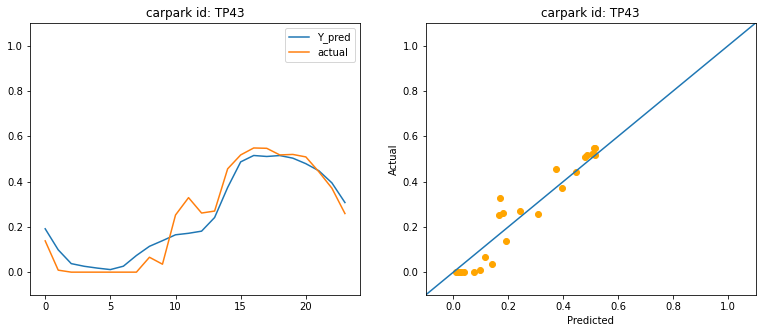

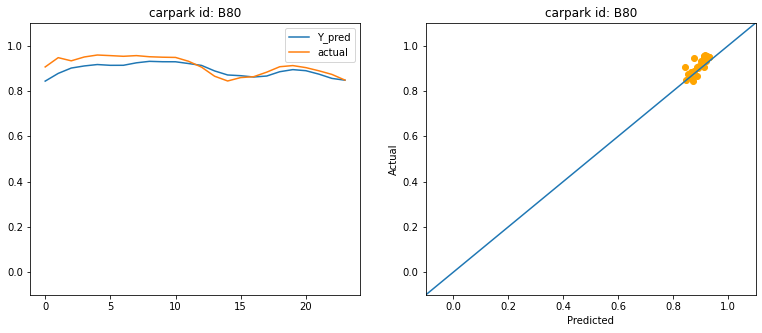

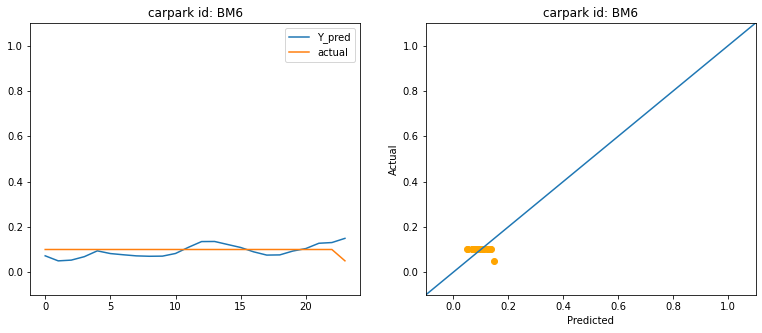

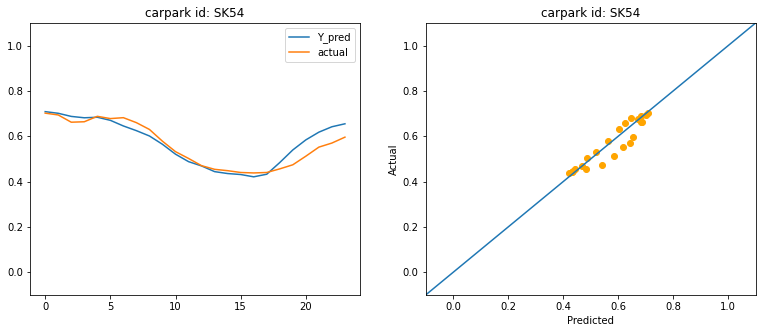

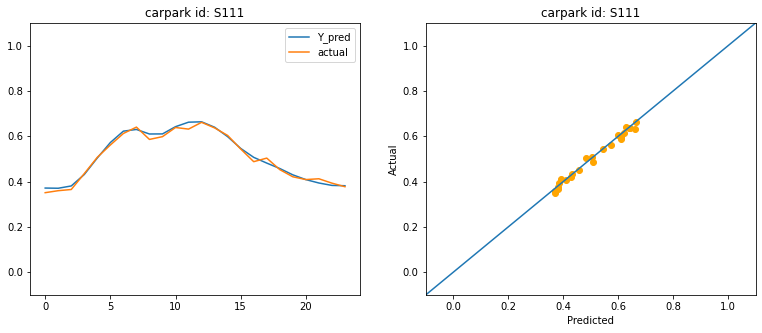

In [14]:
import random
for idx in range(5):
    idx = random.randint(0, len(testX))
    plt.figure(figsize = (13,5))
    plt.subplot(1,2,1)
    plt.ylim(-0.1,1.1)
    plt.title(f"carpark id: {mapTestIdToCarpark(idx)}" )
    plt.plot(Y_pred[idx], label='Y_pred')
    plt.plot(testY[idx], label='actual')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title(f"carpark id: {mapTestIdToCarpark(idx)}" )
    plt.xlim(-0.1,1.1)
    plt.ylim(-.1,1.1)
    plt.scatter(Y_pred[idx], testY[idx], label='Y_pred', color='orange')
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('Actual', fontsize=10)

### General Performance
From the statistic below, The MLP model has a very high R Square value of 0.9476 which indicates a good fit between predicted and actual value. It means that the output's variance can be very well explained by the variance in the input features.

The percentage error at 4.13% means that the predicted values are very close to the actual values.

From these metrics, it can be seen that MLP is a fairly good model for this data distribution.

From the randomly selected scatter plots, we can see that the points are all very close to the line y=x, which means that the predicted availability is very close to the actual availability.

Thus, based on above evidence, the model is a good fit for our distribution. We have established that MLP model is a good fit from Q2 and the above substantiation.

In [15]:
mlp_r2 = metrics.r2_score(testY, Y_pred)
mlp_mse = metrics.mean_squared_error(testY, Y_pred)
mlp_abs_error = mean_absolute_error(testY, Y_pred)
print(f"Model's r2score: {mlp_r2},\nMSE: {mlp_mse},\nMean Absolute Error: {mlp_abs_error*100} %")

Model's r2score: 0.9481734340172521,
MSE: 0.005574083611802591,
Mean Absolute Error: 3.950890297653124 %


## Error across time
Next we try to see how the performance of the model changes according to the prediction hours in future. This is done by plotting the performance metrics - r2score, mean squared error and mean absolute error, accross hours of prediction.

From the graph below, we can see that the model performs very well in the short run. Even though the MSE and MAE increases with prediction hours, the error peak is still within an acceptable range. The R2 score is around 0.93 at 24 hours which still indicates a good fit between actual and predicted values. Overall, the predictions are extremely accurate for the next 24hrs with its accuracy slowly dwindling

Text(0.5, 0, 'Hour')

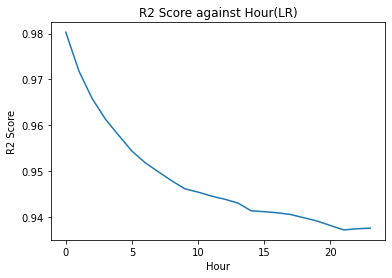

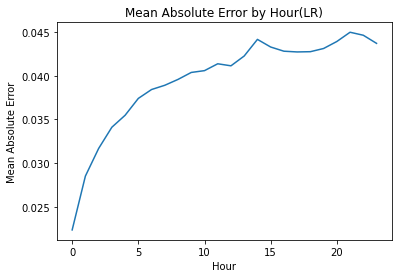

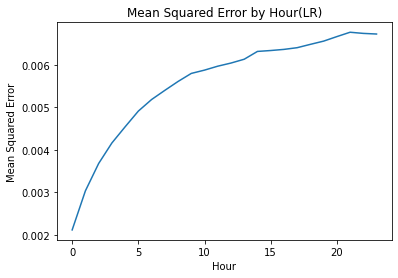

In [16]:
mlp_r2_ls = []
mlp_mse_ls = []
mlp_abs_error_ls = []
for i in range (24):
    mlp_r2_ls.append(metrics.r2_score(testY.transpose()[i], Y_pred.transpose()[i]))
    mlp_mse_ls.append(metrics.mean_squared_error(testY.transpose()[i], Y_pred.transpose()[i]))
    mlp_abs_error_ls.append(mean_absolute_error(testY.transpose()[i], Y_pred.transpose()[i]))
plt.figure()
plt.plot(mlp_r2_ls)
plt.title("R2 Score against Hour(LR)")
plt.ylabel('R2 Score', fontsize=10)
plt.xlabel('Hour', fontsize=10)

plt.figure()
plt.plot(mlp_abs_error_ls)
plt.title("Mean Absolute Error by Hour(LR)")
plt.ylabel('Mean Absolute Error', fontsize=10)
plt.xlabel('Hour', fontsize=10)

plt.figure()
plt.plot(mlp_mse_ls)
plt.title("Mean Squared Error by Hour(LR)")
plt.ylabel('Mean Squared Error', fontsize=10)
plt.xlabel('Hour', fontsize=10)



# Model 2: Linear Regression

In this section, we will use Linear Regression model to predict the parking availability of the next 24 hours. From Q2, we have established that LR model is has generally a better performance than SVR and DT. Here, we will investigate if it has better performance that MLP and LSTM.

First, we fit our LR model with the trainX and trainY. The training and test sets are derived from the original data set with a ratio of 70%:30% respectively.

In [52]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(trainX, trainY)

LinearRegression()

The following kernel is such that the train model will be saved for future runs (assuming training set remains the same).

In [ ]:
# Saving the model
import pickle
pickle.dump(model_lr, open(filename, 'wb'))

In [17]:
# Loading the saved model
filename = 'models/lr_sklearn_model.sav'
model_lr = pickle.load(open(filename, 'rb'))
y_pred_lr = model_lr.predict(testX)
display(trainX)

array([[0.40104167, 0.33984375, 0.328125  , ..., 0.5859375 , 0.5625    ,
        0.51953125],
       [0.33984375, 0.328125  , 0.328125  , ..., 0.5625    , 0.51953125,
        0.46875   ],
       [0.328125  , 0.328125  , 0.32421875, ..., 0.51953125, 0.46875   ,
        0.453125  ],
       ...,
       [0.43772727, 0.43772727, 0.40625   , ..., 0.40625   , 0.40625   ,
        0.40625   ],
       [0.43772727, 0.40625   , 0.40625   , ..., 0.40625   , 0.40625   ,
        0.40625   ],
       [0.40625   , 0.40625   , 0.40625   , ..., 0.40625   , 0.40625   ,
        0.40625   ]])

In [18]:
# Function to map testId to Carpark Id with dropped data accounted for
def mapTestIdToCarpark(testId):
    arr = ["A10","A100","A11","A12","A13","A15","A2","A20","A21","A24","A25","A26","A27","A28","A29","A30","A31","A33","A34","A35","A36","A37","A38","A39","A4","A40","A41","A42","A43","A44","A45","A47","A48","A49","A50","A51","A52","A53","A54","A59","A60","A61","A63","A64","A65","A66","A67","A68","A69","A7","A70","A71","A72","A73","A74","A75","A76","A77","A78","A8","A81","A82","A85","A87","A88","A9","A94","A98","ACB","ACM","AH1","ALL","AM14","AM16","AM18","AM19","AM20","AM22","AM32","AM43","AM46","AM51","AM64","AM79","AM80","AM81","AM96","AR1L","AR1M","AR2L","AR2M","AR5M","AR7L","AR7M","AR9","AV1","B10","B10M","B11","B14","B16","B17","B19","B20","B21","B23M","B23T","B24","B25","B26","B27","B28","B30","B31","B32","B33","B34","B35","B40","B41","B42","B43","B44","B44B","B45","B45A","B45B","B46","B47","B48","B48B","B49","B50","B51","B52","B53","B54","B57","B59","B6","B60","B63","B65","B65L","B65M","B66","B67","B69","B7","B70","B71","B71M","B72","B73","B74","B75","B79","B7A","B7B","B8","B80","B81","B83","B84","B85","B86","B88","B88M","B89","B8B","B9","B90","B90M","B91","B92","B94","B94A","B95","B96","B97","B98","B99M","BA1","BA2","BA3","BA4","BB","BB8M","BBB","BBM1","BBM2","BBM3","BBM5","BBM7","BBM8","BBM9","BE10","BE11","BE12","BE13","BE14","BE18","BE19","BE22","BE23","BE232","BE241","BE25","BE26","BE27","BE28","BE29","BE3","BE30","BE31","BE32","BE33","BE34","BE35","BE36","BE37","BE38","BE39","BE3R","BE4","BE40","BE42","BE44","BE45","BE5","BE6","BE7","BE8","BE9","BH1","BH2","BJ1","BJ10","BJ11","BJ12","BJ13","BJ14","BJ15","BJ16","BJ17","BJ18","BJ19","BJ2","BJ20","BJ21","BJ23","BJ24","BJ25","BJ26","BJ27","BJ28","BJ29","BJ3","BJ30","BJ31","BJ32","BJ33","BJ34","BJ35","BJ36","BJ37","BJ38","BJ39","BJ4","BJ40","BJ41","BJ42","BJ43","BJ44","BJ45","BJ48","BJ49","BJ50","BJ51","BJ52","BJ53","BJ54","BJ55","BJ56","BJ57","BJ58","BJ60","BJ61","BJ62","BJ63","BJ65","BJ66","BJ67","BJ68","BJ69","BJ71","BJ72","BJ8","BJAL","BJBL","BJMP","BKE1","BKE2","BKE3","BKE4","BKE7","BKE9","BKRM","BL10","BL13","BL15","BL17","BL18","BL18M","BL19","BL19S","BL22","BL23","BL3","BL8","BL8L","BLM","BM1","BM10","BM13","BM14","BM19","BM2","BM20","BM26","BM28","BM29","BM3","BM30","BM31","BM4","BM5","BM6","BM9","BMVM","BP1","BP2","BR10","BR11","BR12","BR14","BR4","BR5","BR6","BR8","BR9","BRB1","BRBL","BRM","BRM1","BRM3","BRM4","BRM5","BRM6","BRM7","BTM","BTM2","BTM3","BVM2","BWM","C10","C11","C12","C13M","C14M","C15M","C16","C17","C18","C18A","C19M","C20","C20M","C21L","C21M","C22M","C24","C25","C26","C27","C28M","C29","C29A","C30","C31","C32","C33","C34","C35","C36","C37","C38","C3M","C3ML","C4M","C5","C6","C7","C8","C9","CAM","CC1","CC10","CC11","CC12","CC4","CC5","CC6","CC7","CC8","CC9","CCKC","CDM","CK1","CK10","CK11","CK12","CK13","CK14","CK15","CK16","CK17","CK18","CK19","CK2","CK20","CK21","CK22","CK23","CK24","CK25","CK28","CK29","CK3","CK30","CK31","CK32","CK33","CK34","CK35","CK36","CK37","CK38","CK39","CK3A","CK4","CK40","CK41","CK42","CK44","CK45","CK46","CK47","CK48","CK49","CK50","CK51","CK52","CK53","CK54","CK55","CK56","CK57","CK58","CK59","CK6","CK60","CK61","CK62","CK63","CK64","CK65","CK66","CK6A","CK7","CK70","CK71","CK72","CK73","CK74","CK75","CK76","CK77","CK78","CK8","CK8A","CK9","CK9A","CKM1","CKM2","CKM3","CKM4","CKM5","CKM6","CKM7","CKM8","CKM9","CKT1","CKT2","CLM","CLRG","CLTR","CM1","CR1","CR1A","CR1B","CR2","CR29","CR3","CR30","CR31","CR6","CR7","CSM","CTM1","CV1","CV2","CV3","CVBK","CY","DRM1","DRM2","DRM3","DRM4","DRM5","DRS","DSR1","DSR2","DSRL","DUX","DUXM","DWSO","DWSP","DWST","DWSV","DWVT","EC2","EC3","EC4","EC7","EC8","ECM","EI3","EPL","EPM","EPML","FR2C","FR3M","FR4M","FRM","GBM","GE1A","GE1B","GE1C","GE1F","GE1G","GE2","GE3","GE5","GEM","GEML","GM1A","GM1M","GM2","GM2A","GM3","GM5","GM6A","GM6B","GMLM","GSM","GSML","H12","H14","H17","H18","H3","H4","H6","H8","H93L","HCM","HE1","HE12","HE17","HE19","HE24","HE3","HE4","HE8","HE9","HG1","HG10","HG11","HG12","HG13","HG14","HG15","HG16","HG17","HG18","HG19","HG1A","HG1B","HG1C","HG1D","HG1E","HG1F","HG2","HG20","HG22","HG23","HG24","HG25","HG29","HG2A","HG2B","HG2C","HG2D","HG30","HG31","HG32","HG33","HG34","HG35","HG36","HG37","HG38","HG39","HG3B","HG3D","HG3E","HG3L","HG4","HG41","HG42","HG43","HG44","HG45","HG46","HG47","HG48","HG49","HG5","HG50","HG51","HG52","HG53","HG54","HG55","HG56","HG60","HG61","HG62","HG64","HG67","HG68","HG69","HG7","HG70","HG71","HG73","HG74","HG75","HG76","HG77","HG78","HG79","HG80","HG86","HG87","HG88","HG89","HG9","HG90","HG91","HG92","HG93","HG94","HG95","HG96","HG97","HG98","HG99","HG9T","HLM","HR1","HR2","HR3","HR4","HR5","HRM","HVM","J1","J10","J11","J12","J14","J15","J16","J17","J18","J19","J2","J20","J21","J22","J23","J23M","J24","J25","J26","J27","J29","J3","J32","J33","J34","J35","J36","J37","J38","J39","J4","J40","J41","J43","J44","J45","J46","J47","J48","J49","J49M","J5","J50","J51","J52","J53","J54","J55","J56","J57","J57L","J6","J60L","J60M","J61","J62","J62M","J63","J64","J65","J66","J67","J68M","J69","J7","J70","J71","J72","J73","J74","J74M","J75M","J76M","J77M","J78M","J79M","J8","J80M","J80MS","J80S","J81M","J82M","J83M","J84M","J84S","J85M","J86M","J86S","J88M","J89M","J8M","J9","J90","J91","J92","J93","J94","J95","J96","J97","J98M","J99M","JB1","JB2","JB3","JB4","JB42","JBM","JBM2","JCM","JCML","JKM","JKS","JM1","JM10","JM11","JM12","JM13","JM13S","JM14","JM15","JM16","JM17","JM18","JM19","JM2","JM20","JM21","JM22","JM23","JM24","JM25","JM26","JM27","JM28","JM29","JM3","JM30","JM31","JM32","JM4","JM5","JM6","JM7","JM7M","JM8","JM8M","JM9","JMB1","JMB2","JMB3","JMSC","JMSU","JRM","JRTM","JS1L","JS3L","JS4L","JS5L","JSA1","JSR1","JSR2","K10","K19","K2","K2T","K52","K7","KAM","KAML","KAMS","KAS","KB1","KB10","KB11","KB12","KB14","KB17","KB18","KB20","KB3","KB4","KB7","KBM","KE1","KE2","KE3","KE3M","KE4","KEM1","KJ1","KJ2","KJ3","KJ4","KJM1","KJM2","KJML","KLM","KM1","KM2","KM3","KM4","KRM","KTM","KTM2","KTM3","KTM4","KTM5","KTM6","KU1","KU2","KU3","KU4","KU9","L1","LBM","LT1","LT2","LT3","LUB","M1","M16","M20","M25","M3","M32","M33","M35","M36","M37","M38","M4","MLM","MLM1","MM1","MM2","MM3","MM4","MM6","MN1","MN2","MNM","MNRM","MP1","MP12","MP13","MP14","MP15","MP16","MP17","MP19","MP1M","MP2","MP2M","MP3M","MP4M","MP5","MP5M","MP5S","MP6","MP7","MPS","MR4","MR5","MR567","MR6","MR7","N0012","NBRM","NT1","NT2","NT3","NT4","NT5","NTL","P1","P11","P12","P13","P14","P15","P16","P17","P2","P3","P34L","P35L","P4","P40L","P40L1","P40L2","P5","P5L","P6","P6L","P6M","P7","P73L","P8","P9","PD8W","PDC4","PDC5","PDJ3","PDJ7","PDL2","PDP4","PDP5","PDQ5","PDR2","PDR6","PDR7","PDS1","PDT8","PDW5","PDW7","PDW8","PGS","PL10","PL11","PL12","PL13","PL14","PL15","PL16","PL17","PL18","PL19","PL20","PL21","PL22","PL23","PL24","PL25","PL26","PL27","PL28","PL29","PL30","PL31","PL32","PL33","PL34","PL35","PL36","PL37","PL38","PL39","PL40","PL41","PL42","PL43","PL44","PL45","PL46","PL47","PL48","PL49","PL50","PL51","PL52","PL53","PL54","PL55","PL56","PL57","PL58","PL59","PL60","PL61","PL62","PL65","PL66","PL67","PL68","PL69","PL70","PL71","PL75","PL77","PL78","PM10","PM11","PM12","PM13","PM14","PM15","PM16","PM17","PM18","PM19","PM2","PM20","PM21","PM22","PM23","PM24","PM25","PM26","PM27","PM28","PM29","PM3","PM30","PM32","PM33","PM34","PM35","PM36","PM37","PM38","PM4","PM40","PM41","PM43","PM44","PM45","PM46","PM5","PM6","PM7","PM8","PM9","PP1","PP2","PP3","PP4","PP5","PP6","PP9T","PR1","PR10","PR12","PR13","PR14","PR2","PR3","PR4","PR6","PR7","PR8","PRM","PRS1","Q16","Q16A","Q17","Q19","Q41","Q65","Q66","Q67","Q68","Q70","Q73","Q75M","Q77M","Q8","Q80","Q81","Q82","Q84","Q85","Q86","Q87","Q88","Q89","Q94","Q96","RC1","RC2","RC3","RCB","RCM","RH3","RHM","RHM2","RHM3","RHM4","RHS","S100","S102","S103","S104","S105","S106","S107","S108","S109","S110","S111","S113","S114","S116","S13L","S14L","S15L","S19L","S24L","S28L","S30L","S36L","S38L","S39L","S40L","SAM","SAM2","SB1","SB10","SB11","SB12","SB13","SB15","SB16","SB17","SB18","SB19","SB2","SB20","SB21","SB22","SB23","SB24","SB25","SB26","SB27","SB28","SB28L","SB29","SB3","SB30","SB31","SB32","SB33","SB34","SB35","SB36","SB37","SB38","SB39","SB4","SB40","SB41","SB42","SB43","SB44","SB45","SB46","SB47","SB5","SB6","SB7","SB8","SB9","SD1","SD11","SD2","SD3","SD4","SD5","SD9","SDM","SDM2","SE11","SE12","SE13","SE14","SE15","SE16","SE17","SE18","SE19","SE20","SE21","SE22","SE23","SE24","SE25","SE26","SE27","SE28","SE29","SE31","SE32","SE33","SE34","SE35","SE37","SE38","SE39","SE40","SE41","SE42","SE43","SE50","SE51","SE52","SE53","SE5L","SE9","SG1","SG2","SG3","SG4","SGLM","SGTM","SH1","SH2","SI1","SI10","SI11","SI12","SI13","SI2","SI4","SI6","SI7","SI8","SI9","SIM1","SIM2","SIM3","SIM4","SIM5","SIM6","SK1","SK10","SK11","SK12","SK13","SK14","SK15","SK16","SK17","SK18","SK19","SK2","SK20","SK21","SK22","SK23","SK24","SK25","SK26","SK27","SK28","SK29","SK3","SK30","SK31","SK32","SK33","SK34","SK35","SK36","SK37","SK38","SK39","SK4","SK40","SK41","SK42","SK43","SK44","SK45","SK46","SK47","SK48","SK49","SK5","SK50","SK51","SK52","SK53","SK54","SK55","SK58","SK59","SK6","SK60","SK61","SK62","SK63","SK64","SK65","SK66","SK67","SK68","SK69","SK7","SK70","SK71","SK72","SK73","SK74","SK75","SK76","SK77","SK78","SK79","SK8","SK80","SK81","SK82","SK83","SK84","SK85","SK86","SK87","SK88","SK89","SK9","SK90","SK91","SK92","SK93","SK94","SK95","SK96","SK97","SK98","SK99","SLS","SM1","SM3","SM9","SM9A","SM9B","SMM","SPM","SPS","STAM","STM1","STM2","STM3","T1","T11","T12","T13","T15","T16","T17","T18","T19","T20","T24","T25","T26","T27","T28","T29","T3","T30","T31","T32","T34","T35","T37","T38","T39","T4","T41","T42","T43","T44","T45","T46","T47","T47A","T48","T49","T49A","T50","T51","T55","T57","T58","T7","T72","T73","T74","T75","T76","T77","T78","T79","T7A","T8","T80","T81","T9","TAM1","TAM2","TB1","TB10","TB11","TB14","TB17","TB18","TB19","TB2","TB22","TB23","TB28","TB3","TB4A","TB6","TB7","TB8","TB9","TBC2","TBC3","TBCM","TBL","TBM","TBM2","TBM3","TBM4","TBM5","TBM6","TBM7","TBM8","TBMT","TE1","TE13","TE14","TE2","TE25","TE3","TE4","TEST","TG1","TG2","TG3","TG6","TG7","TGM1","TGM2","TGM3","TGM4","TGML","TJ27","TJ28","TJ28M","TJ29","TJ30","TJ30S","TJ31","TJ32","TJ33","TJ33S","TJ34","TJ35","TJ36","TJ37","TJ38","TJ39","TJ41","TJ42","TJSF","TM10","TM11","TM12","TM13","TM14","TM15","TM16","TM17","TM18","TM19","TM20","TM21","TM22","TM23","TM24","TM25","TM26","TM27","TM28","TM29","TM3","TM30","TM31","TM32","TM33","TM34","TM35","TM36","TM37","TM4","TM41","TM42","TM43","TM44","TM45","TM46","TM47","TM48","TM49","TM5","TM50","TM51","TM52","TM53","TM54","TM55","TM6","TM7","TM8","TM9","TP10","TP12","TP14","TP15","TP16","TP17","TP18","TP2","TP20","TP22","TP27","TP3","TP30","TP31","TP34","TP36","TP3A","TP40","TP41","TP43","TP48","TP49","TP4A","TP50","TP52","TP53","TP54","TP60","TP62","TP63","TP67","TP68","TP7","TP8","TPB1","TPL","TPM","TPM2","TPM3","TPM4","TPM5","TPM6","TPM7","TPM8","TPM9","TPMA","TPMB","TPMC","TPMD","TPME","TPMF","TPMG","TPMH","TPMJ","TPMK","TPML","TPMM","TPMN","TPMP","TPMQ","TPMR","TR1","TRM","TRS","TW1","TW2","TW3","TW4","TWM1","TWM2","TWM3","TWM4","U1","U10","U11","U12","U13","U15","U17","U18","U19","U2","U21","U22","U23","U24","U24T","U25","U26","U27","U28","U29","U3","U30","U31","U32","U33","U34","U38","U39","U4","U40","U41","U43","U43Z","U45","U46","U48","U5","U50","U51","U52","U54","U55","U56","U57","U58","U6","U60","U63","U64","U65","U66","U68","U69","U7","U70","U8","U9","UA2","UA3","UA5","UAM1","UBK2","UBK4","UBK5","UBKM","UBM1","UBM2","W1","W10","W100","W101","W102","W103","W104","W105","W106","W107","W108","W109","W11","W11M","W12L","W12M","W13","W14","W15","W17","W18","W181","W182","W185","W19","W2","W20","W21","W23","W24","W25","W26","W27","W28","W3","W30","W36","W37","W39","W4","W40","W41","W43","W44","W45","W46","W48","W49","W4M","W5","W50","W505","W509","W51","W516","W517","W52","W527","W53","W536","W54","W546","W549","W55","W554","W56","W56L","W57","W570","W574","W578","W579","W58","W586","W588","W59","W5M","W6","W61","W64","W65","W66","W67","W676","W68","W69","W691","W693","W694","W7","W70","W71","W717","W72","W73","W74","W75","W76","W77","W78","W780","W782","W783","W785","W79","W80","W81","W82","W83","W84","W85","W86","W87","W88","W887","W889","W89","W8M","W90","W91","W92","W93","W94","W95","W96","W98","WCB","WCC","WD1B","WDB1","Y1","Y10","Y11","Y12","Y13","Y14","Y15","Y16","Y17","Y18","Y19","Y2","Y20","Y21","Y21M","Y23","Y24","Y25","Y25M","Y26","Y27","Y28","Y28M","Y29","Y3","Y30M","Y31","Y32","Y33","Y34","Y34A","Y35","Y36","Y38","Y39","Y3M","Y4","Y40","Y41","Y41M","Y43","Y45","Y45M","Y46","Y48","Y48M","Y49","Y49HV","Y49L","Y49M","Y5","Y51","Y51M","Y52M","Y53M","Y54M","Y56","Y57","Y58","Y59M","Y6","Y60M","Y61M","Y62M","Y63M","Y64M","Y65M","Y66M","Y68L","Y68M","Y69M","Y7","Y70M","Y71M","Y73M","Y74M","Y75M","Y76M","Y77L","Y77M","Y78M","Y8","Y82M","Y9","YHS"]
    return arr[int(testId/1330)]

This section will randomly select 10 carparks and display the actual and predicted data for the time frame. This is solely for visualisation purposes. 

randomList: [2223157, 1456359, 267629, 1571377, 873060, 1167269, 2348988, 2070408, 1850009, 1586663]


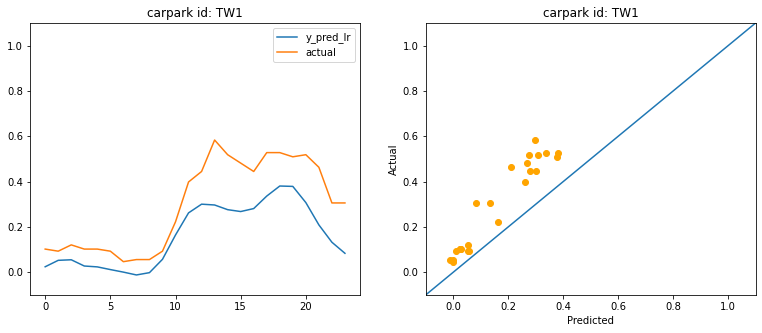

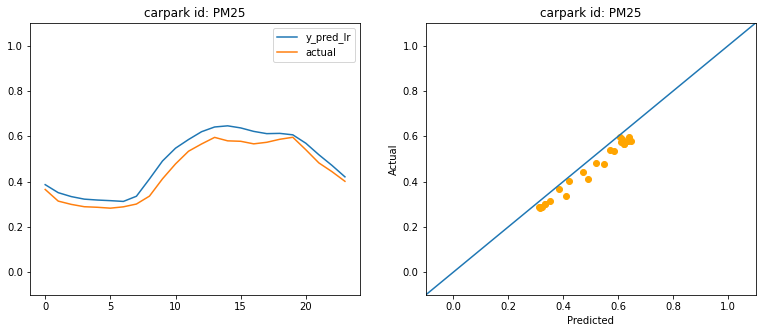

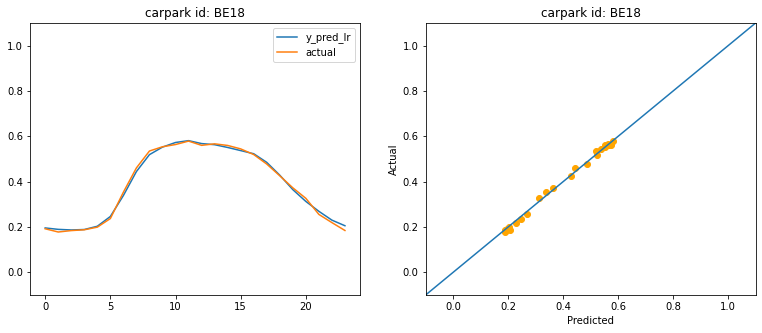

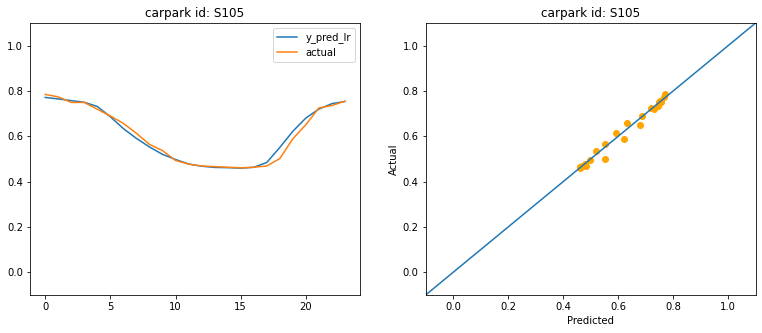

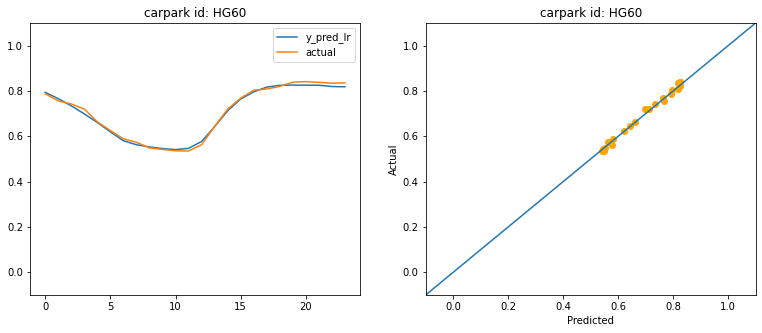

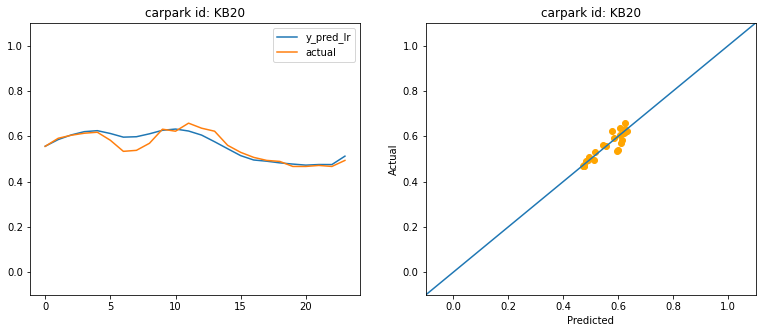

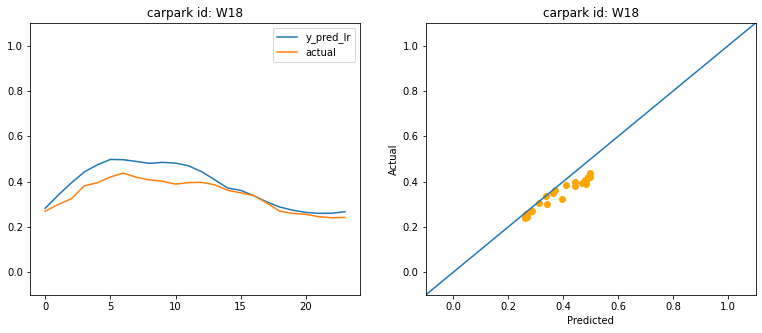

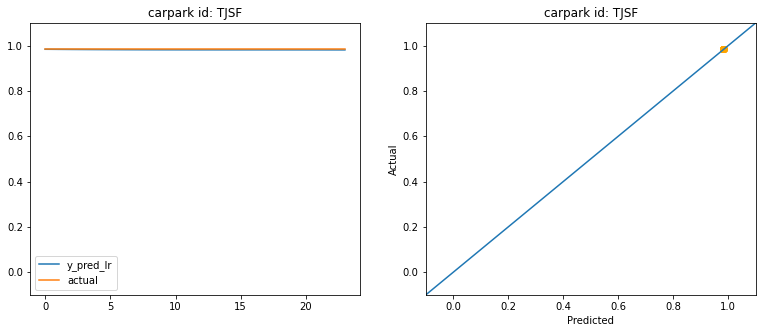

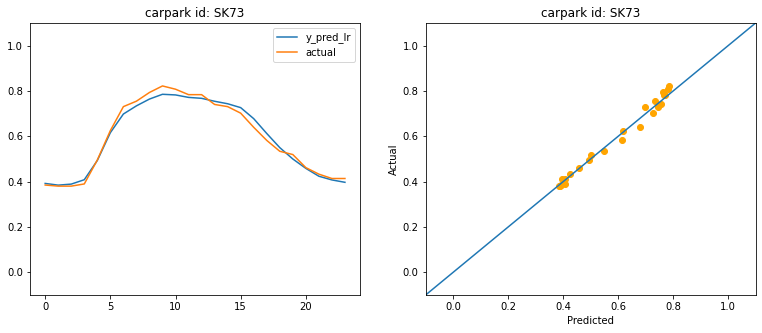

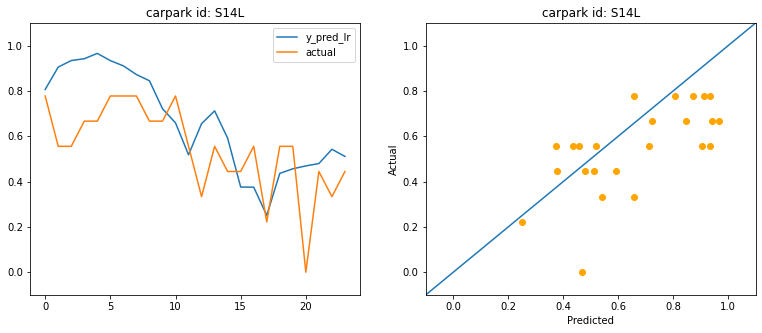

In [20]:
import random
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
randomList = [random.randint(0,len(testY)) for i in range(10)]
print(f"randomList: {randomList}")

for i in randomList:
    plt.figure(figsize = (13,5))
    plt.subplot(1,2,1)
    plt.ylim(-0.1,1.1)
    plt.title(f"carpark id: {mapTestIdToCarpark(i)}" )
    plt.plot(y_pred_lr[i], label='y_pred_lr')
    plt.plot(testY[i], label='actual')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title(f"carpark id: {mapTestIdToCarpark(i)}" )
    plt.xlim(-0.1,1.1)
    plt.ylim(-.1,1.1)
    plt.scatter(y_pred_lr[i], testY[i], label='y_pred_lr', color='orange')
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('Actual', fontsize=10)


### Intepretation of model's performance
The LR model has a very high R Square value of 0.948 which indicates a good fit between predicted and actual value. It means that the output's variance can be very well explained by the variance in the input features.

The percentage error at 4.07% means that the predicted values are very close to the actual values.

From these metrics, it can be seen that LR is a fairly good model for this data distribution.

From the randomly selected scatter plots, we can see that the points are all very close to the line y=x, which means that the predicted availability is very close to the actual availability.

Thus, based on above evidence, the model is a good fit for our distribution. We have established that LR model is a good fit from Q2 and the above substantiation.

In [21]:
lr_r2 = metrics.r2_score(testY, y_pred_lr)
lr_mse = metrics.mean_squared_error(testY, y_pred_lr)
lr_abs_error = mean_absolute_error(testY, y_pred_lr)
print(f"Model's r2score: {lr_r2},\nMSE: {lr_mse},\nMean Absolute Error: {lr_abs_error*100} %\n")

Model's r2score: 0.9480106634767015,
MSE: 0.005591564842698374,
Mean Absolute Error: 4.0711792803509494 %



### Error vs Time graph
From the graphs below, we can see that our predictions are extremely accurate in the short run and we can see that mean absolute error plateaus at a low value that is less than 0.045. The mean squared error can also be seen increasing at a decreasing rate to about 0.65% at 20hrs after the keyed in time. Overall, the predictions are extremely accurate for the next 24hrs with its accuracy slowly dwindling 



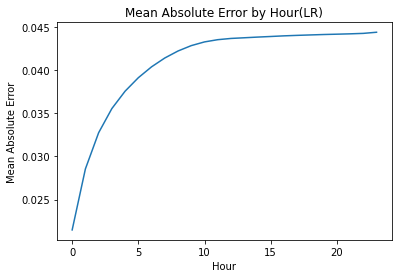

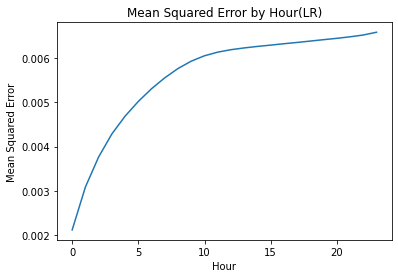

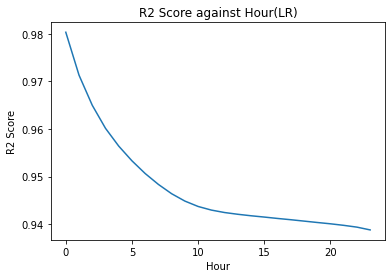

In [22]:
ae_by_hr = []
mse_by_hr = []
r2_by_hr = []
for i in range(24):
    # print("Hour{}:   MSE is {}" .format(i,mean_squared_error(testY[:,i], y_pred_lr[:,i])) )
    # print("               R2 Score is {}" .format(r2_score(testY[:,i], y_pred_lr[:,i])) )
    mse = mean_squared_error(testY[:,i], y_pred_lr[:,i])
    ae = mean_absolute_error(testY[:,i], y_pred_lr[:,i])
    r2 = r2_score(testY[:,i], y_pred_lr[:,i])
    # print("               Absolute Error is {}%" .format(100*ae))
    ae_by_hr.append(ae)
    mse_by_hr.append(mse)
    r2_by_hr.append(r2)
plt.plot(ae_by_hr)
plt.title("Mean Absolute Error by Hour(LR)")
plt.ylabel('Mean Absolute Error', fontsize=10)
plt.xlabel('Hour', fontsize=10)
plt.show()
plt.plot(mse_by_hr)
plt.title("Mean Squared Error by Hour(LR)")
plt.ylabel('Mean Squared Error', fontsize=10)
plt.xlabel('Hour', fontsize=10)
plt.show()
plt.plot(r2_by_hr)
plt.title("R2 Score against Hour(LR)")
plt.ylabel('R2 Score', fontsize=10)
plt.xlabel('Hour', fontsize=10)
plt.show()

# Model 3: LSTM
This is a proble where, given the parking availability of the past 8*24 hours,we are trying to predict the parking availability of the next 24 hour of a specific carpark. The data ranges from July 2022 to September 2022. 
In this section we will use the Long Short-Term Memory network to predict the parking availability. LSTM is good at predicting time-series data, we will investigeate whether it has better performance than MLP and LR.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

The LSTM network expects the input data to be provided with a specific array structure in the form of [samples, time steps, features]. Currently the data is in the form of [samples,time]

In [25]:
# reshape input to be [samples, time steps, features]
trainX1 = np.reshape(trainX, (trainX.shape[0], 8, 24))
testX1 = np.reshape(testX, (testX.shape[0], 8, 24))
print(trainX1.shape)
print(trainY.shape)


(874606, 8, 24)
(874606, 24)


In [44]:
# create and fit the LSTM network
modelX = Sequential()
modelX.add(LSTM(8, input_shape=(8,24), activation="relu"))
modelX.add(Dense(24))
modelX.compile(loss='mean_squared_error', optimizer='adam')
modelX.fit(trainX1, trainY, epochs=50, batch_size=64, verbose=2)

Epoch 1/50
13666/13666 - 61s - loss: 0.0134 - 61s/epoch - 4ms/step
Epoch 2/50
13666/13666 - 62s - loss: 0.0063 - 62s/epoch - 5ms/step
Epoch 3/50
13666/13666 - 59s - loss: 0.0059 - 59s/epoch - 4ms/step
Epoch 4/50
13666/13666 - 58s - loss: 0.0056 - 58s/epoch - 4ms/step
Epoch 5/50
13666/13666 - 58s - loss: 0.0056 - 58s/epoch - 4ms/step
Epoch 6/50
13666/13666 - 58s - loss: 0.0054 - 58s/epoch - 4ms/step
Epoch 7/50
13666/13666 - 58s - loss: 0.0053 - 58s/epoch - 4ms/step
Epoch 8/50
13666/13666 - 58s - loss: 0.0052 - 58s/epoch - 4ms/step
Epoch 9/50
13666/13666 - 58s - loss: 0.0052 - 58s/epoch - 4ms/step
Epoch 10/50
13666/13666 - 58s - loss: 0.0052 - 58s/epoch - 4ms/step
Epoch 11/50
13666/13666 - 59s - loss: 0.0052 - 59s/epoch - 4ms/step
Epoch 12/50
13666/13666 - 58s - loss: 0.0052 - 58s/epoch - 4ms/step
Epoch 13/50
13666/13666 - 58s - loss: 0.0052 - 58s/epoch - 4ms/step
Epoch 14/50
13666/13666 - 58s - loss: 0.0051 - 58s/epoch - 4ms/step
Epoch 15/50
13666/13666 - 59s - loss: 0.0051 - 59s/epoch 

In [45]:
# Save the model
# model.save('models/lstm_tf_model.h5')
modelX.save('models/lstm_tf_model_824.h5')

In [26]:
loaded = tf.keras.models.load_model('models/lstm_tf_model_824.h5')
ypred_lstm = loaded.predict(testX1)
print(ypred_lstm.shape)
#show model info
# print(modelX.summary())
# print(testX[0].shape)
# modelX(testX1[0])

81505/81505 [==============================] - 65s 789us/step
(2608130, 24)


In [27]:
# Function to map testId to Carpark Id with dropped data accounted for
def mapTestIdToCarpark(testId):
    arr = ["A10","A100","A11","A12","A13","A15","A2","A20","A21","A24","A25","A26","A27","A28","A29","A30","A31","A33","A34","A35","A36","A37","A38","A39","A4","A40","A41","A42","A43","A44","A45","A47","A48","A49","A50","A51","A52","A53","A54","A59","A60","A61","A63","A64","A65","A66","A67","A68","A69","A7","A70","A71","A72","A73","A74","A75","A76","A77","A78","A8","A81","A82","A85","A87","A88","A9","A94","A98","ACB","ACM","AH1","ALL","AM14","AM16","AM18","AM19","AM20","AM22","AM32","AM43","AM46","AM51","AM64","AM79","AM80","AM81","AM96","AR1L","AR1M","AR2L","AR2M","AR5M","AR7L","AR7M","AR9","AV1","B10","B10M","B11","B14","B16","B17","B19","B20","B21","B23M","B23T","B24","B25","B26","B27","B28","B30","B31","B32","B33","B34","B35","B40","B41","B42","B43","B44","B44B","B45","B45A","B45B","B46","B47","B48","B48B","B49","B50","B51","B52","B53","B54","B57","B59","B6","B60","B63","B65","B65L","B65M","B66","B67","B69","B7","B70","B71","B71M","B72","B73","B74","B75","B79","B7A","B7B","B8","B80","B81","B83","B84","B85","B86","B88","B88M","B89","B8B","B9","B90","B90M","B91","B92","B94","B94A","B95","B96","B97","B98","B99M","BA1","BA2","BA3","BA4","BB","BB8M","BBB","BBM1","BBM2","BBM3","BBM5","BBM7","BBM8","BBM9","BE10","BE11","BE12","BE13","BE14","BE18","BE19","BE22","BE23","BE232","BE241","BE25","BE26","BE27","BE28","BE29","BE3","BE30","BE31","BE32","BE33","BE34","BE35","BE36","BE37","BE38","BE39","BE3R","BE4","BE40","BE42","BE44","BE45","BE5","BE6","BE7","BE8","BE9","BH1","BH2","BJ1","BJ10","BJ11","BJ12","BJ13","BJ14","BJ15","BJ16","BJ17","BJ18","BJ19","BJ2","BJ20","BJ21","BJ23","BJ24","BJ25","BJ26","BJ27","BJ28","BJ29","BJ3","BJ30","BJ31","BJ32","BJ33","BJ34","BJ35","BJ36","BJ37","BJ38","BJ39","BJ4","BJ40","BJ41","BJ42","BJ43","BJ44","BJ45","BJ48","BJ49","BJ50","BJ51","BJ52","BJ53","BJ54","BJ55","BJ56","BJ57","BJ58","BJ60","BJ61","BJ62","BJ63","BJ65","BJ66","BJ67","BJ68","BJ69","BJ71","BJ72","BJ8","BJAL","BJBL","BJMP","BKE1","BKE2","BKE3","BKE4","BKE7","BKE9","BKRM","BL10","BL13","BL15","BL17","BL18","BL18M","BL19","BL19S","BL22","BL23","BL3","BL8","BL8L","BLM","BM1","BM10","BM13","BM14","BM19","BM2","BM20","BM26","BM28","BM29","BM3","BM30","BM31","BM4","BM5","BM6","BM9","BMVM","BP1","BP2","BR10","BR11","BR12","BR14","BR4","BR5","BR6","BR8","BR9","BRB1","BRBL","BRM","BRM1","BRM3","BRM4","BRM5","BRM6","BRM7","BTM","BTM2","BTM3","BVM2","BWM","C10","C11","C12","C13M","C14M","C15M","C16","C17","C18","C18A","C19M","C20","C20M","C21L","C21M","C22M","C24","C25","C26","C27","C28M","C29","C29A","C30","C31","C32","C33","C34","C35","C36","C37","C38","C3M","C3ML","C4M","C5","C6","C7","C8","C9","CAM","CC1","CC10","CC11","CC12","CC4","CC5","CC6","CC7","CC8","CC9","CCKC","CDM","CK1","CK10","CK11","CK12","CK13","CK14","CK15","CK16","CK17","CK18","CK19","CK2","CK20","CK21","CK22","CK23","CK24","CK25","CK28","CK29","CK3","CK30","CK31","CK32","CK33","CK34","CK35","CK36","CK37","CK38","CK39","CK3A","CK4","CK40","CK41","CK42","CK44","CK45","CK46","CK47","CK48","CK49","CK50","CK51","CK52","CK53","CK54","CK55","CK56","CK57","CK58","CK59","CK6","CK60","CK61","CK62","CK63","CK64","CK65","CK66","CK6A","CK7","CK70","CK71","CK72","CK73","CK74","CK75","CK76","CK77","CK78","CK8","CK8A","CK9","CK9A","CKM1","CKM2","CKM3","CKM4","CKM5","CKM6","CKM7","CKM8","CKM9","CKT1","CKT2","CLM","CLRG","CLTR","CM1","CR1","CR1A","CR1B","CR2","CR29","CR3","CR30","CR31","CR6","CR7","CSM","CTM1","CV1","CV2","CV3","CVBK","CY","DRM1","DRM2","DRM3","DRM4","DRM5","DRS","DSR1","DSR2","DSRL","DUX","DUXM","DWSO","DWSP","DWST","DWSV","DWVT","EC2","EC3","EC4","EC7","EC8","ECM","EI3","EPL","EPM","EPML","FR2C","FR3M","FR4M","FRM","GBM","GE1A","GE1B","GE1C","GE1F","GE1G","GE2","GE3","GE5","GEM","GEML","GM1A","GM1M","GM2","GM2A","GM3","GM5","GM6A","GM6B","GMLM","GSM","GSML","H12","H14","H17","H18","H3","H4","H6","H8","H93L","HCM","HE1","HE12","HE17","HE19","HE24","HE3","HE4","HE8","HE9","HG1","HG10","HG11","HG12","HG13","HG14","HG15","HG16","HG17","HG18","HG19","HG1A","HG1B","HG1C","HG1D","HG1E","HG1F","HG2","HG20","HG22","HG23","HG24","HG25","HG29","HG2A","HG2B","HG2C","HG2D","HG30","HG31","HG32","HG33","HG34","HG35","HG36","HG37","HG38","HG39","HG3B","HG3D","HG3E","HG3L","HG4","HG41","HG42","HG43","HG44","HG45","HG46","HG47","HG48","HG49","HG5","HG50","HG51","HG52","HG53","HG54","HG55","HG56","HG60","HG61","HG62","HG64","HG67","HG68","HG69","HG7","HG70","HG71","HG73","HG74","HG75","HG76","HG77","HG78","HG79","HG80","HG86","HG87","HG88","HG89","HG9","HG90","HG91","HG92","HG93","HG94","HG95","HG96","HG97","HG98","HG99","HG9T","HLM","HR1","HR2","HR3","HR4","HR5","HRM","HVM","J1","J10","J11","J12","J14","J15","J16","J17","J18","J19","J2","J20","J21","J22","J23","J23M","J24","J25","J26","J27","J29","J3","J32","J33","J34","J35","J36","J37","J38","J39","J4","J40","J41","J43","J44","J45","J46","J47","J48","J49","J49M","J5","J50","J51","J52","J53","J54","J55","J56","J57","J57L","J6","J60L","J60M","J61","J62","J62M","J63","J64","J65","J66","J67","J68M","J69","J7","J70","J71","J72","J73","J74","J74M","J75M","J76M","J77M","J78M","J79M","J8","J80M","J80MS","J80S","J81M","J82M","J83M","J84M","J84S","J85M","J86M","J86S","J88M","J89M","J8M","J9","J90","J91","J92","J93","J94","J95","J96","J97","J98M","J99M","JB1","JB2","JB3","JB4","JB42","JBM","JBM2","JCM","JCML","JKM","JKS","JM1","JM10","JM11","JM12","JM13","JM13S","JM14","JM15","JM16","JM17","JM18","JM19","JM2","JM20","JM21","JM22","JM23","JM24","JM25","JM26","JM27","JM28","JM29","JM3","JM30","JM31","JM32","JM4","JM5","JM6","JM7","JM7M","JM8","JM8M","JM9","JMB1","JMB2","JMB3","JMSC","JMSU","JRM","JRTM","JS1L","JS3L","JS4L","JS5L","JSA1","JSR1","JSR2","K10","K19","K2","K2T","K52","K7","KAM","KAML","KAMS","KAS","KB1","KB10","KB11","KB12","KB14","KB17","KB18","KB20","KB3","KB4","KB7","KBM","KE1","KE2","KE3","KE3M","KE4","KEM1","KJ1","KJ2","KJ3","KJ4","KJM1","KJM2","KJML","KLM","KM1","KM2","KM3","KM4","KRM","KTM","KTM2","KTM3","KTM4","KTM5","KTM6","KU1","KU2","KU3","KU4","KU9","L1","LBM","LT1","LT2","LT3","LUB","M1","M16","M20","M25","M3","M32","M33","M35","M36","M37","M38","M4","MLM","MLM1","MM1","MM2","MM3","MM4","MM6","MN1","MN2","MNM","MNRM","MP1","MP12","MP13","MP14","MP15","MP16","MP17","MP19","MP1M","MP2","MP2M","MP3M","MP4M","MP5","MP5M","MP5S","MP6","MP7","MPS","MR4","MR5","MR567","MR6","MR7","N0012","NBRM","NT1","NT2","NT3","NT4","NT5","NTL","P1","P11","P12","P13","P14","P15","P16","P17","P2","P3","P34L","P35L","P4","P40L","P40L1","P40L2","P5","P5L","P6","P6L","P6M","P7","P73L","P8","P9","PD8W","PDC4","PDC5","PDJ3","PDJ7","PDL2","PDP4","PDP5","PDQ5","PDR2","PDR6","PDR7","PDS1","PDT8","PDW5","PDW7","PDW8","PGS","PL10","PL11","PL12","PL13","PL14","PL15","PL16","PL17","PL18","PL19","PL20","PL21","PL22","PL23","PL24","PL25","PL26","PL27","PL28","PL29","PL30","PL31","PL32","PL33","PL34","PL35","PL36","PL37","PL38","PL39","PL40","PL41","PL42","PL43","PL44","PL45","PL46","PL47","PL48","PL49","PL50","PL51","PL52","PL53","PL54","PL55","PL56","PL57","PL58","PL59","PL60","PL61","PL62","PL65","PL66","PL67","PL68","PL69","PL70","PL71","PL75","PL77","PL78","PM10","PM11","PM12","PM13","PM14","PM15","PM16","PM17","PM18","PM19","PM2","PM20","PM21","PM22","PM23","PM24","PM25","PM26","PM27","PM28","PM29","PM3","PM30","PM32","PM33","PM34","PM35","PM36","PM37","PM38","PM4","PM40","PM41","PM43","PM44","PM45","PM46","PM5","PM6","PM7","PM8","PM9","PP1","PP2","PP3","PP4","PP5","PP6","PP9T","PR1","PR10","PR12","PR13","PR14","PR2","PR3","PR4","PR6","PR7","PR8","PRM","PRS1","Q16","Q16A","Q17","Q19","Q41","Q65","Q66","Q67","Q68","Q70","Q73","Q75M","Q77M","Q8","Q80","Q81","Q82","Q84","Q85","Q86","Q87","Q88","Q89","Q94","Q96","RC1","RC2","RC3","RCB","RCM","RH3","RHM","RHM2","RHM3","RHM4","RHS","S100","S102","S103","S104","S105","S106","S107","S108","S109","S110","S111","S113","S114","S116","S13L","S14L","S15L","S19L","S24L","S28L","S30L","S36L","S38L","S39L","S40L","SAM","SAM2","SB1","SB10","SB11","SB12","SB13","SB15","SB16","SB17","SB18","SB19","SB2","SB20","SB21","SB22","SB23","SB24","SB25","SB26","SB27","SB28","SB28L","SB29","SB3","SB30","SB31","SB32","SB33","SB34","SB35","SB36","SB37","SB38","SB39","SB4","SB40","SB41","SB42","SB43","SB44","SB45","SB46","SB47","SB5","SB6","SB7","SB8","SB9","SD1","SD11","SD2","SD3","SD4","SD5","SD9","SDM","SDM2","SE11","SE12","SE13","SE14","SE15","SE16","SE17","SE18","SE19","SE20","SE21","SE22","SE23","SE24","SE25","SE26","SE27","SE28","SE29","SE31","SE32","SE33","SE34","SE35","SE37","SE38","SE39","SE40","SE41","SE42","SE43","SE50","SE51","SE52","SE53","SE5L","SE9","SG1","SG2","SG3","SG4","SGLM","SGTM","SH1","SH2","SI1","SI10","SI11","SI12","SI13","SI2","SI4","SI6","SI7","SI8","SI9","SIM1","SIM2","SIM3","SIM4","SIM5","SIM6","SK1","SK10","SK11","SK12","SK13","SK14","SK15","SK16","SK17","SK18","SK19","SK2","SK20","SK21","SK22","SK23","SK24","SK25","SK26","SK27","SK28","SK29","SK3","SK30","SK31","SK32","SK33","SK34","SK35","SK36","SK37","SK38","SK39","SK4","SK40","SK41","SK42","SK43","SK44","SK45","SK46","SK47","SK48","SK49","SK5","SK50","SK51","SK52","SK53","SK54","SK55","SK58","SK59","SK6","SK60","SK61","SK62","SK63","SK64","SK65","SK66","SK67","SK68","SK69","SK7","SK70","SK71","SK72","SK73","SK74","SK75","SK76","SK77","SK78","SK79","SK8","SK80","SK81","SK82","SK83","SK84","SK85","SK86","SK87","SK88","SK89","SK9","SK90","SK91","SK92","SK93","SK94","SK95","SK96","SK97","SK98","SK99","SLS","SM1","SM3","SM9","SM9A","SM9B","SMM","SPM","SPS","STAM","STM1","STM2","STM3","T1","T11","T12","T13","T15","T16","T17","T18","T19","T20","T24","T25","T26","T27","T28","T29","T3","T30","T31","T32","T34","T35","T37","T38","T39","T4","T41","T42","T43","T44","T45","T46","T47","T47A","T48","T49","T49A","T50","T51","T55","T57","T58","T7","T72","T73","T74","T75","T76","T77","T78","T79","T7A","T8","T80","T81","T9","TAM1","TAM2","TB1","TB10","TB11","TB14","TB17","TB18","TB19","TB2","TB22","TB23","TB28","TB3","TB4A","TB6","TB7","TB8","TB9","TBC2","TBC3","TBCM","TBL","TBM","TBM2","TBM3","TBM4","TBM5","TBM6","TBM7","TBM8","TBMT","TE1","TE13","TE14","TE2","TE25","TE3","TE4","TEST","TG1","TG2","TG3","TG6","TG7","TGM1","TGM2","TGM3","TGM4","TGML","TJ27","TJ28","TJ28M","TJ29","TJ30","TJ30S","TJ31","TJ32","TJ33","TJ33S","TJ34","TJ35","TJ36","TJ37","TJ38","TJ39","TJ41","TJ42","TJSF","TM10","TM11","TM12","TM13","TM14","TM15","TM16","TM17","TM18","TM19","TM20","TM21","TM22","TM23","TM24","TM25","TM26","TM27","TM28","TM29","TM3","TM30","TM31","TM32","TM33","TM34","TM35","TM36","TM37","TM4","TM41","TM42","TM43","TM44","TM45","TM46","TM47","TM48","TM49","TM5","TM50","TM51","TM52","TM53","TM54","TM55","TM6","TM7","TM8","TM9","TP10","TP12","TP14","TP15","TP16","TP17","TP18","TP2","TP20","TP22","TP27","TP3","TP30","TP31","TP34","TP36","TP3A","TP40","TP41","TP43","TP48","TP49","TP4A","TP50","TP52","TP53","TP54","TP60","TP62","TP63","TP67","TP68","TP7","TP8","TPB1","TPL","TPM","TPM2","TPM3","TPM4","TPM5","TPM6","TPM7","TPM8","TPM9","TPMA","TPMB","TPMC","TPMD","TPME","TPMF","TPMG","TPMH","TPMJ","TPMK","TPML","TPMM","TPMN","TPMP","TPMQ","TPMR","TR1","TRM","TRS","TW1","TW2","TW3","TW4","TWM1","TWM2","TWM3","TWM4","U1","U10","U11","U12","U13","U15","U17","U18","U19","U2","U21","U22","U23","U24","U24T","U25","U26","U27","U28","U29","U3","U30","U31","U32","U33","U34","U38","U39","U4","U40","U41","U43","U43Z","U45","U46","U48","U5","U50","U51","U52","U54","U55","U56","U57","U58","U6","U60","U63","U64","U65","U66","U68","U69","U7","U70","U8","U9","UA2","UA3","UA5","UAM1","UBK2","UBK4","UBK5","UBKM","UBM1","UBM2","W1","W10","W100","W101","W102","W103","W104","W105","W106","W107","W108","W109","W11","W11M","W12L","W12M","W13","W14","W15","W17","W18","W181","W182","W185","W19","W2","W20","W21","W23","W24","W25","W26","W27","W28","W3","W30","W36","W37","W39","W4","W40","W41","W43","W44","W45","W46","W48","W49","W4M","W5","W50","W505","W509","W51","W516","W517","W52","W527","W53","W536","W54","W546","W549","W55","W554","W56","W56L","W57","W570","W574","W578","W579","W58","W586","W588","W59","W5M","W6","W61","W64","W65","W66","W67","W676","W68","W69","W691","W693","W694","W7","W70","W71","W717","W72","W73","W74","W75","W76","W77","W78","W780","W782","W783","W785","W79","W80","W81","W82","W83","W84","W85","W86","W87","W88","W887","W889","W89","W8M","W90","W91","W92","W93","W94","W95","W96","W98","WCB","WCC","WD1B","WDB1","Y1","Y10","Y11","Y12","Y13","Y14","Y15","Y16","Y17","Y18","Y19","Y2","Y20","Y21","Y21M","Y23","Y24","Y25","Y25M","Y26","Y27","Y28","Y28M","Y29","Y3","Y30M","Y31","Y32","Y33","Y34","Y34A","Y35","Y36","Y38","Y39","Y3M","Y4","Y40","Y41","Y41M","Y43","Y45","Y45M","Y46","Y48","Y48M","Y49","Y49HV","Y49L","Y49M","Y5","Y51","Y51M","Y52M","Y53M","Y54M","Y56","Y57","Y58","Y59M","Y6","Y60M","Y61M","Y62M","Y63M","Y64M","Y65M","Y66M","Y68L","Y68M","Y69M","Y7","Y70M","Y71M","Y73M","Y74M","Y75M","Y76M","Y77L","Y77M","Y78M","Y8","Y82M","Y9","YHS"]
    return arr[int(testId/1330)]

randomList: [2360739, 1238626, 395386, 355500, 2582425, 2474045, 2192558, 763662, 1292142, 731914]


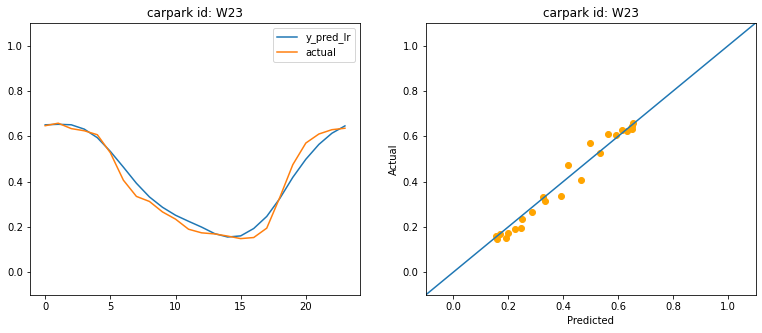

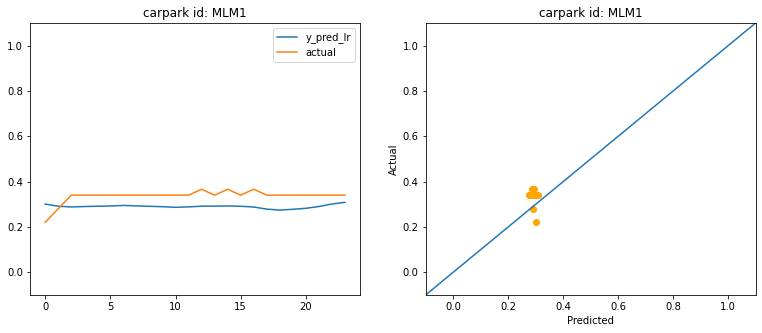

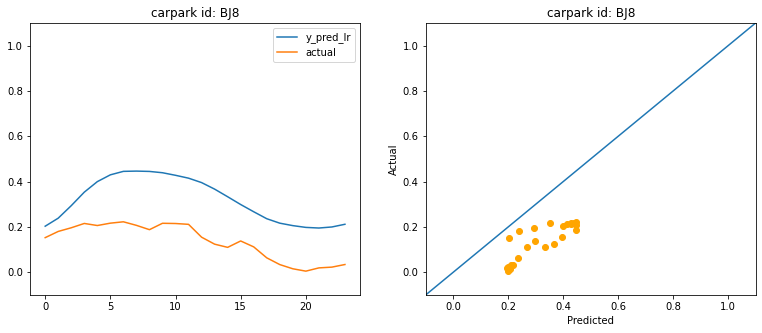

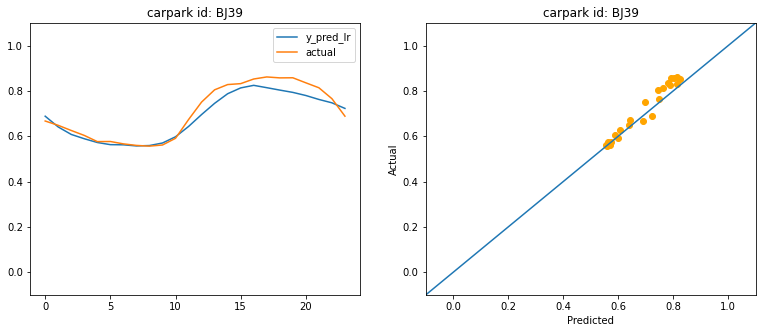

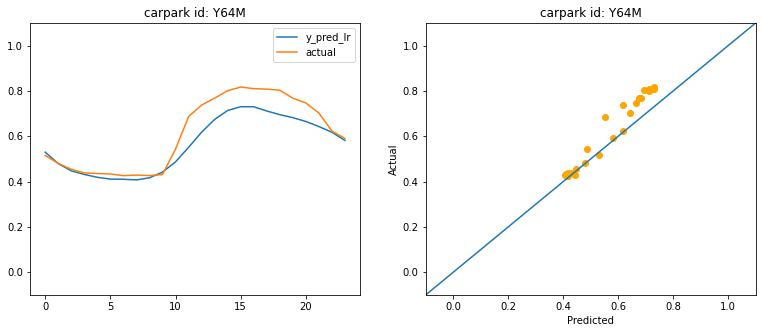

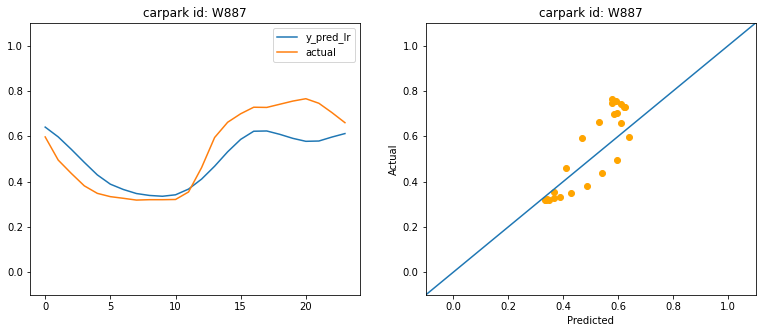

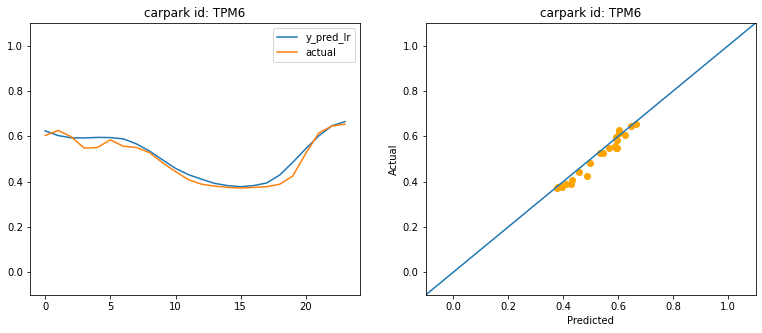

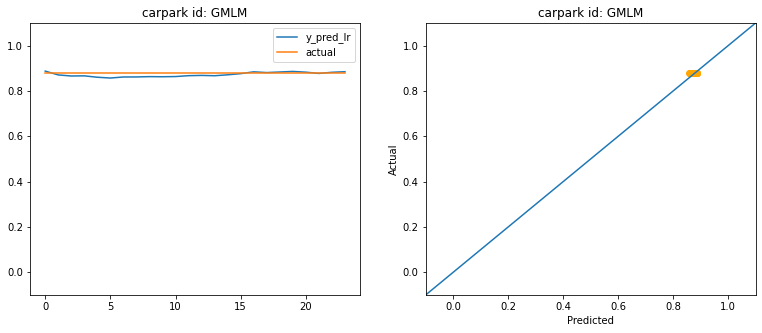

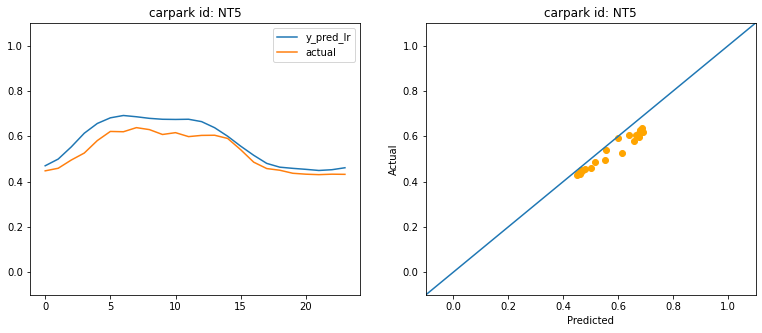

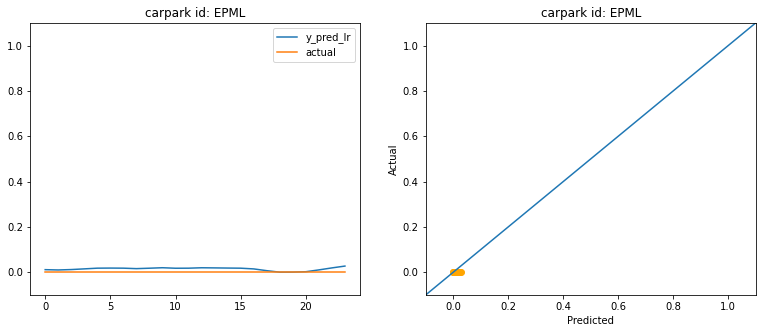

In [28]:
import random
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
randomList = [random.randint(0,len(testY)) for i in range(10)]
print(f"randomList: {randomList}")

for i in randomList:
    plt.figure(figsize = (13,5))
    plt.subplot(1,2,1)
    plt.ylim(-0.1,1.1)
    plt.title(f"carpark id: {mapTestIdToCarpark(i)}" )
    plt.plot(ypred_lstm[i], label='y_pred_lr')
    plt.plot(testY[i], label='actual')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title(f"carpark id: {mapTestIdToCarpark(i)}" )
    plt.xlim(-0.1,1.1)
    plt.ylim(-.1,1.1)
    plt.scatter(ypred_lstm[i], testY[i], label='y_pred_lr', color='orange')
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('Actual', fontsize=10)

### Intepretation of model's performance
The LR model has a very high R Square value of 0.948 which indicates a good fit between predicted and actual value. It means that the output's variance can be very well explained by the variance in the input features.

The percentage error at 4.07% means that the predicted values are very close to the actual values.

From these metrics, it can be seen that LR is a fairly good model for this data distribution.

From the randomly selected scatter plots, we can see that the points are all very close to the line y=x, which means that the predicted availability is very close to the actual availability.

Thus, based on above evidence, the model is a good fit for our distribution. We have established that LR model is a good fit from Q2 and the above substantiation.

In [29]:
lstm_r2 = metrics.r2_score(testY, ypred_lstm)
lstm_mse = metrics.mean_squared_error(testY, ypred_lstm)
lstm_abs_error = mean_absolute_error(testY, ypred_lstm)
print(f"Model's r2score: {lstm_r2},\nMSE: {lstm_mse},\nMean Absolute Error: {lstm_abs_error*100} %\n")

Model's r2score: 0.9465795668153526,
MSE: 0.005745453025413467,
Mean Absolute Error: 4.315765648142372 %



### Error vs Time graph¶
From the graphs below, we can see that our predictions are extremely accurate in the short run and we can see that mean absolute error plateaus at a low value that is less than 0.045. The mean squared error can also be seen increasing at a decreasing rate to about 0.65% at 20hrs after the keyed in time. Overall, the predictions are extremely accurate for the next 24hrs with its accuracy slowly dwindling

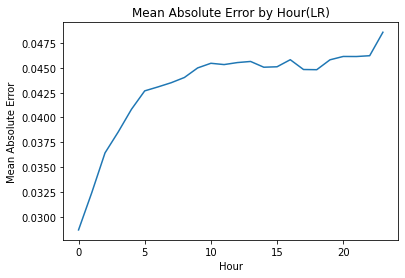

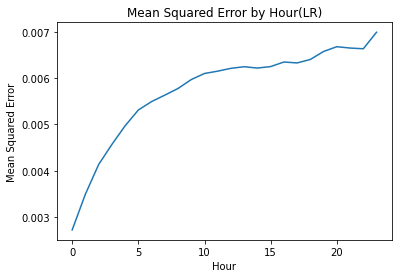

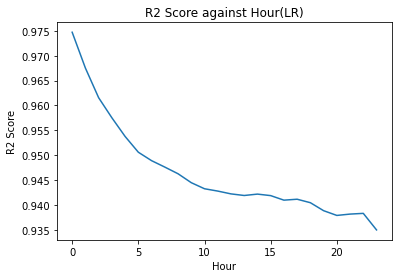

In [30]:
ae_by_hr = []
mse_by_hr = []
r2_by_hr = []
for i in range(24):
    # print("Hour{}:   MSE is {}" .format(i,mean_squared_error(testY[:,i], y_pred_lr[:,i])) )
    # print("               R2 Score is {}" .format(r2_score(testY[:,i], y_pred_lr[:,i])) )
    mse = mean_squared_error(testY[:,i], ypred_lstm[:,i])
    ae = mean_absolute_error(testY[:,i], ypred_lstm[:,i])
    r2 = r2_score(testY[:,i], ypred_lstm[:,i])
    # print("               Absolute Error is {}%" .format(100*ae))
    ae_by_hr.append(ae)
    mse_by_hr.append(mse)
    r2_by_hr.append(r2)
plt.plot(ae_by_hr)
plt.title("Mean Absolute Error by Hour(LR)")
plt.ylabel('Mean Absolute Error', fontsize=10)
plt.xlabel('Hour', fontsize=10)
plt.show()
plt.plot(mse_by_hr)
plt.title("Mean Squared Error by Hour(LR)")
plt.ylabel('Mean Squared Error', fontsize=10)
plt.xlabel('Hour', fontsize=10)
plt.show()
plt.plot(r2_by_hr)
plt.title("R2 Score against Hour(LR)")
plt.ylabel('R2 Score', fontsize=10)
plt.xlabel('Hour', fontsize=10)
plt.show()

# Model Comparison


In [34]:
pd_list = np.array([[mlp_r2,lr_r2,lstm_r2],[mlp_mse,lr_mse,lstm_mse],[mlp_abs_error*100,lr_abs_error*100,lstm_abs_error*100]])
df = pd.DataFrame(pd_list.transpose(), index = ['MLP', 'LR', 'LSTM'], columns = ['r2score', 'RMS', 'Mean Absolute error (%)'])
print('Model Perfomance')
display(df)


Model Perfomance


,r2score,RMS,Mean Absolute error (%)
MLP,0.948173,0.005574,3.950890
LR,0.948011,0.005592,4.071179
LSTM,0.946580,0.005745,4.315766


Based on the selected performance metrics, we identify MLP as the final selected models for our carpark recommendation system

# Proposed solution

Based on the above evaluation, we selected MLP model with 2 hidden layers of 200, 50 neurons each. Using the model, we developed a simple application that can help users predict the availabilty of nearby carparks for the next 24 hours.<br>The user will key in a postal code that they wish to visit in the next few hours. The application will help the user to find the nearby 5 carparks and predict their availability. The users can determine during time periods will the parking slots be more available and plan their visit accordingly. This hopes to reduce the problem of carpark shortage.

In [1]:
#import libraries
from queue import PriorityQueue
from datetime import timedelta
import pickle
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import pandas as pd
import numpy as np
from termcolor import colored
import warnings
warnings.filterwarnings("ignore")

from api_utils import getDataAtTimestamp, json2csv, postalcode2xy

### Helper methods to our app

In [2]:
def update_rencet_csv(time_now, recent):
    '''
    update recent data from API and store locally in a csv file
    '''
    range = timedelta(hours=191)
    start = time_now - range
    end = time_now
    for date in pd.date_range(start, end, freq='1h'):
        if date not in recent.index:
            recent.loc[date] = 1
            year, month, day, hour, mins = date.year, date.month, date.day, date.hour, date.minute+1
            try:
                raw_data = getDataAtTimestamp(str(year), str(month), str(day), str(hour), str(mins))
            except:
                continue
            raw_df = json2csv(raw_data, date)
            raw_df['lots_available'] = raw_df['lots_available'].astype(float)
            raw_df['total_lots'] = raw_df['total_lots'].astype(float)
            raw_df['available rate'] = raw_df['lots_available'] / raw_df['total_lots']
            for id in raw_df.carpark_number:
                if id in recent.columns:
                    recent.loc[date, id] = raw_df[raw_df.carpark_number == id]['available rate'].values[0]
                else:
                    print("Id not seen!")
    recent.fillna(method='ffill', inplace=True)
    recent.to_csv("./data/recent.csv")

def find_nearest(x, y, location_dict) -> List[Tuple[float, str]]:
    '''
    Sort carparks by distance to the given location
    '''
    shortest = PriorityQueue()
    for key, (loc, addr) in location_dict.items():
        dist = (loc[0] - x)**2 + (loc[1] - y)**2
        shortest.put((-dist, key))
    size = shortest.qsize()
    res = [shortest.get() for i in range(size)]
    res.reverse()
    return res

def create_location_dict(loc_info: pd.DataFrame) -> Dict[str, Tuple[Tuple[float, float], str]]:
    '''
    Create a dictionary of carparks' location and address with carpark number as key
    '''
    location_dict = {}
    for row in loc_info.iterrows():
        content = row[1]
        name = content[0]
        addr = content[1]
        location = (content[2], content[3])
        location_dict[name] = (location, addr)
    return location_dict

def init():
    '''
    Initialize the app data, including recent data, location dictionary and model
    '''
    model = pickle.load(open('models/mlp_sklearn_model.sav', 'rb'))
    print(colored("Model loaded!", "green"))
    recent = pd.read_csv("./data/recent.csv")
    recent['timestamp'] = pd.to_datetime(recent['timestamp'])
    recent = recent.set_index('timestamp')
    print(colored("Recent data loaded!", "green"))
    loc_info = pd.read_csv("./data/hdb-carpark-information.csv")
    location_info = create_location_dict(loc_info)
    return model, recent, location_info

def get_pred_inputs(recent: pd.DataFrame, id: str):
    '''
    Get the inputs for the model from the recent data based on the carpark number
    '''
    time_now = pd.Timestamp.now()
    time_now = time_now.floor('1h')
    range = timedelta(hours=192)
    if time_now not in recent.index:
        print(colored("Updating recent data! Please wait", "green"))
        update_rencet_csv(time_now, recent)
    most_recent = recent[id][time_now - range: time_now]
    return most_recent.values.reshape(1, -1)

def find_by_location(model,
                                    recent: pd.DataFrame,
                                    carpark_info: Dict[str, Tuple[Tuple[float, float], str]],
                                    x, y):
    """
    Find the nearest 5 carparks to the given location and predict the available rate
    """
    print(colored("Finding nearest carpark...", "green"))
    top5 = find_nearest(x, y, carpark_info)
    res = []
    for ele in top5:
        id = ele[1]
        if id not in recent.columns:
            print(f"We do not have data for the nearby carpark {id}")
            continue
        input = get_pred_inputs(recent, id)
        prediction = model.predict(input)[0]
        res.append((ele[0], ele[1], prediction))
        if (len(res) == 5):
            break
    return res

### main app flow

In [3]:
def app():
    model, recent, location_dict = init()
    print("* Welcome to the carpark availability prediction system")
    print("* Where would you like to go?")

    while True:
        postal_code = input("Enter your destination postal code: ")
        print(postal_code)
        try:
            x, y = postalcode2xy(postal_code)
            best_options = find_by_location(model, recent, location_dict, x, y)
            break
        except Exception as e:
            print(e)
            print(colored("Invalid Postal Code! Please Try Again", "red"))

    print(colored("Best options is:"))
    print(colored(f"carpark {best_options[0][1]} with distance {-best_options[0][0]}", 'yellow'))
    print(colored("Alternatives are:"))
    for ele in best_options[1:]:
        print(colored(f"carpark {ele[1]} with distance {-ele[0]}"))

    time_now = pd.Timestamp.now()
    time_now = time_now.ceil('1h')
    ranges = [(time_now + timedelta(hours=i)).time() for i in range(0,24,4)]
    print(ranges)
    fig, axs = plt.subplots(min(5, len(best_options)+1), 1, figsize=(10, 25))
    for i in range(len(best_options)):
        axs[i].plot(best_options[i][2])
        axs[i].set_xticks(range(0, 24, 4))
        axs[i].set_xticklabels(ranges)
        axs[i].set_ylim(0, 1)
        axs[i].set_title(f"carpark at {location_dict[best_options[i][1]][1]}\n Distance {-best_options[i][0]}",fontsize=10)
    plt.show()


### Run the app

Model loaded!
Recent data loaded!
* Welcome to the carpark availability prediction system
* Where would you like to go?
138600
Finding nearest carpark...
Best options is:
carpark C3M with distance 427263.02948714676
Alternatives are:
carpark C3ML with distance 606583.3338573483
carpark C4M with distance 610861.7729772844
carpark C33 with distance 629935.6217044649
carpark AR2L with distance 647373.7372743348
[datetime.time(22, 0), datetime.time(2, 0), datetime.time(6, 0), datetime.time(10, 0), datetime.time(14, 0), datetime.time(18, 0)]


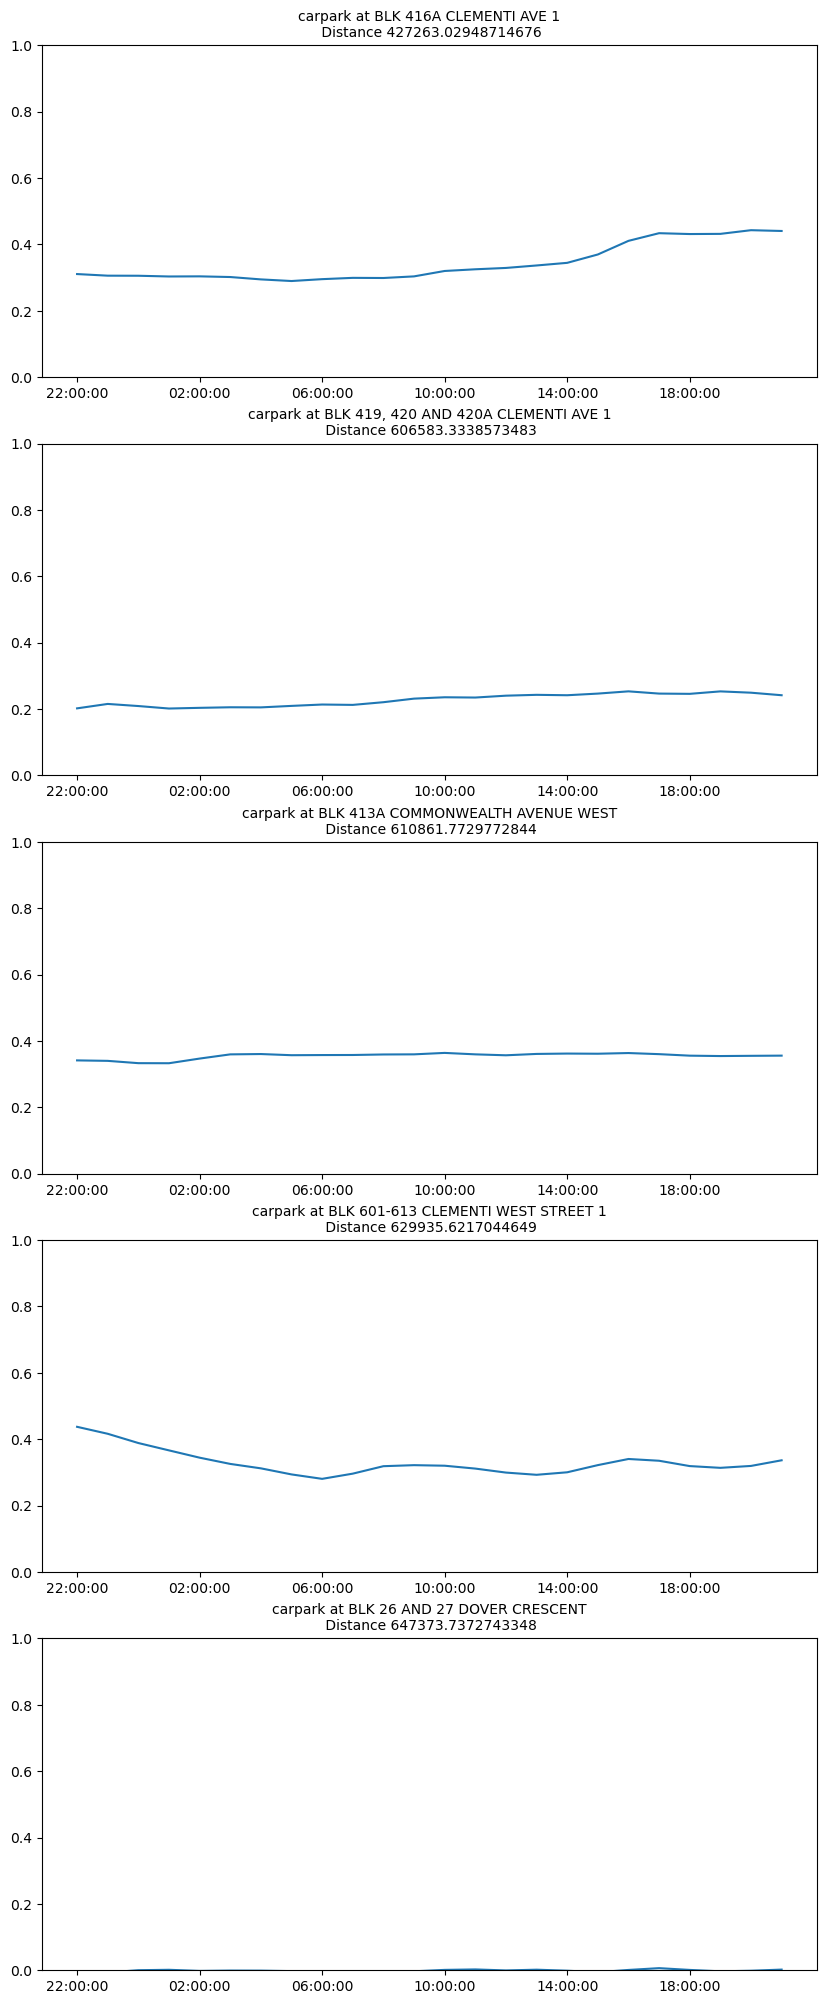

In [4]:
app()

## Suggestions
### Suggestions to drivers
It is encouraged for drivers to plan ahead for their trip and checkout their destination's parking availability before they leave using our application. This will help them avoid the hassle of driving around looking for parking. Based on our analysis, the model is sufficiently effect to predict the next 24 hours.

### Suggestions to carpark managers
It is encouraged to allow data collection on a wider range of carparks such as private carparks. This will help to improve the accuracy of the model and give better recommendations to the users. In addition, it would be more helpful to collect more information such as the exact incoming and leaving time of each car. Based on average parking time, the carpark managers can determine whether or not to install electrical charging stations for electric cars. This will make the dataset more useful for the purpose of data science.